#### packages and functions

In [1]:
from pathlib import Path
import numpy as np 
import h5py
import matplotlib.pyplot as plt
import time
import os
from scipy import signal
import matplotlib.colors as colors
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import axes3d
from scipy.optimize import curve_fit
from scipy.special import erf
import scipy.io
import colorsys
from scipy import signal
import math
from scipy.stats import norm
import pickle
import os
import pandas as pd

import ipyparams
from e6py import E6math
from e6py import Photontimer
from e6py import smart_gaussian2d_fit


<IPython.core.display.Javascript object>

In [2]:
from scipy.interpolate import interp1d

# def uniquebin(x, y):
#     xbin = np.unique(np.array(x).astype('float'))
#     ybin = xbin * 0;
#     ybinerr = xbin * 0;
#     for i in range(0, len(xbin)):
#         ytemplist = y[x == xbin[i]]
#         ybin[i] = np.nanmean(ytemplist)
#         ybinerr[i] = np.nanstd(ytemplist)
    
#     return xbin, ybin, ybinerr

def uniquebin(x, y):
    xbin = np.unique(np.array(x).astype('float'))
    ybin = xbin * 0;
    ybinerr = xbin * 0;
    ybinmean_err = xbin * 0;
    for i in range(0, len(xbin)):
        ytemplist = y[x == xbin[i]]
        ybin[i] = np.nanmean(ytemplist)
        ybinerr[i] = np.nanstd(ytemplist)
        ybinmean_err[i] = ybinerr[i]/np.sqrt(np.sum(x == xbin[i]))
    return xbin, ybin, ybinerr,ybinmean_err


def rabi_oscillation_t(tau,fR,phi,A=1,offset=0):
    return A*np.cos(2*np.pi*tau*fR+phi)+offset


def rabi_oscillation(tau=0, fR=3e3, delta=0, f=None, f0=None):
    if (f0 is not None) and (f is not None): delta = f0-f
    elif f0 is not None: delta=0.0
    elif f is not None: delta=0.0
    return fR**2 / (fR**2 + delta**2) * np.sin(np.pi * tau * (fR**2 + delta**2)**(1/2))**2

def rabi_oscillation_decoherence(tau=0, fR=3e3, gamma=0, Amp=1, offset=0):
    w=np.exp(-0.5*gamma*tau)*(np.cos(2*np.pi*np.sqrt(fR**2-(gamma/2)**2)*tau)+(gamma/2/np.sqrt(fR**2-(gamma/2)**2))*np.sin(2*np.pi*np.sqrt(fR**2-(gamma/2)**2)*tau))
    return Amp*(1-w)/2+offset

def butter_lowpass_filter(data, cutoff, order):
    b, a = signal.butter(order, cutoff, btype='low', analog=False)
    y = signal.filtfilt(b, a, data)
    return y


def exp_fun_2(t,alpha,A=1,B=0):
    return A*np.exp(-2*alpha*t)+B


def exp_fun(t,gamma,A=1,B=0):
    return A*np.exp(-gamma*t)+B

# x_int=np.array([0,0.7 ,0.8, 0.9, 1   ,1.1,  1.2, 1.3,  1.4,  1.5, 1.6,   1.7  ,1.8  ,2.0  ,2.1  ,2.2  ,2.5  ,3  ,3.5, 4  ,4.5,5  ,5.5,6  ,6.5,7.5,8.5,10])
# y_int=np.array([0,0.99,7.18,20.7,41.3,65.3, 90.5,115.4,138.1,159.0,178.5,195.6,210.3,236.7,248.4,258.7,283.8,314,335, 349,361,370,376,383,388,397,402,408])

x_int=np.array([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,1.7,1.8,1.9,2,2.2,2.5,2.75,3,3.25,3.5,4,4.5,5,6,7,8,9,10])
y_int=np.array([0.01,0.05,0.37,1.61,4.6,10.33,19.55,32.62,49.72,70.12,93.72,119.12,145.82,174.32,203.32,232.32,288.52,311.92,
                335.92,355.92,387.92,411.92,421.92,428.92,430.92,433.92,437.92,441.92,442.92,445.92,447.92,449.92,449.92,451.42])
y_int=y_int/np.max(y_int)
power_curve= interp1d(x_int,y_int,kind='slinear')

def ControlV_Power(x,maximum_power=1):
    return maximum_power*power_curve(x)

def double_lorentzian_fit(f, A, B, kappa, gamma, f0):
    return A/(1+(2*(f-f0)/kappa)**2) + B/(1+(2*(f-f0)/gamma)**2)

def lorentzian_fit(f, A, kappa, f0):
    return A/(1+(2*(f-f0)/kappa)**2)

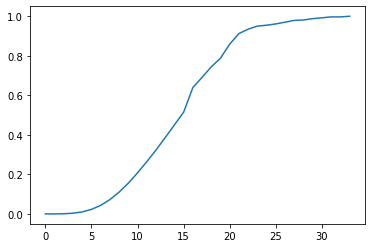

In [3]:
plt.plot(power_curve(x_int))

In [4]:
# simulated N scaling
# 512MHz g0=3.1MHz
N_sim=np.array([ 1,  2,  3,  4,  5,  6, 7,  8])

rel_cav_height_10nm_512MHz=np.array([ 1.        ,  3.9932454 ,  8.97666513, 15.94504205, 24.88395339,
       35.800021  , 48.67755505, 63.52935801])
rel_cav_height_130nm_512MHz=np.array([ 1.        ,  3.50127715,  7.53997985, 13.00364974, 20.4688463 ,
       28.4414432 , 38.86101047, 49.20170356])
rel_cav_height_150nm_512MHz=np.array([ 1.        ,  3.24543437,  6.4885979 , 11.24202425, 17.41620041,
       24.46064153, 32.54476083, 41.89095921])

rel_cav_weight_10nm_512MHz=np.array([ 1.        ,  3.99523801,  8.9856586 , 15.96919352, 24.93404818,
       35.88833457, 48.82018323, 63.7452156 ])
rel_cav_weight_130nm_512MHz=np.array([ 1.        ,  3.50267269,  7.54650876, 13.02259644, 20.50677823,
       28.50735218, 38.97035077, 49.3646424 ])
rel_cav_weight_150nm_512MHz=np.array([ 1.        ,  3.24677217,  6.49427329, 11.25711612, 17.4485312 ,
       24.51886691, 32.63516859, 42.02741649])


shift_sim_10nm_512MHz=np.array([-0.01894299, -0.03786727, -0.05680144, -0.07574188, -0.09466694,
       -0.11360509, -0.1325311 , -0.15147438])
shift_sim_130nm_512MHz=np.array([-0.01538429, -0.02865735, -0.04121567, -0.05446417, -0.06770355,
       -0.0797003 , -0.09273594, -0.1045913 ])
shift_sim_150nm_512MHz=np.array([-0.01513781, -0.02757617, -0.03933482, -0.05132907, -0.06360572,
       -0.07492203, -0.0868774 , -0.09839016])

width_sim_10nm_512MHz=np.array([0.53025615, 0.53051427, 0.53077022, 0.53102726, 0.53128471,
       0.53154183, 0.53179986, 0.53205581])
width_sim_130nm_512MHz=np.array([0.530239  , 0.53047341, 0.53070598, 0.53096488, 0.53119116,
       0.53142854, 0.53166353, 0.53188658])
width_sim_150nm_512MHz=np.array([0.53023666, 0.53047224, 0.53070898, 0.53093774, 0.53117223,
       0.53140884, 0.53163139, 0.53187685])


###### Cavity Fluorescence 

## Load data

### User input section

In [89]:
########################### User input section ############################
# run info
currentnotebook_name = ipyparams.notebook_name
run_name = currentnotebook_name[:-6]
run_name = 'run0'

#Boolean input
override_num_shots = False
reset_hard = False #only set this to true if you want to reload from raw data


#number input
# num_shots_manual = 39
num_shots_manual = 500

num_frames = 3

outer_zoom_factor = 5



point_name_outer = 'sideprobe_intensity'
point_name_inner = 'cav_pzt'

point_list_outer = np.array([1.7]) #ControlV_Power(np.array([1,1.2,1.4,1.6,1.8,2,2.5,4]))
point_list_inner = np.linspace(-0.6,0.6,7)

# point_list_inner = np.linspace(0.35,0.5,4)

tweezer_freq_list = 88 + 0.8*0 + 0.8*np.arange(40)

twz_num_plot=np.array([18])


atom_site = []
for i in range(num_frames):
    atom_site.append(np.arange(len(tweezer_freq_list)))

#################################################################################
num_points_inner = len(point_list_inner)
num_points_outer = len(point_list_outer)
if num_points_outer == 1:
    point_list = np.array(point_list_inner)
else:
    point_list = (outer_zoom_factor*np.outer(point_list_outer,np.ones(len(point_list_inner))) + np.outer(np.ones(len(point_list_outer)),point_list_inner)).flatten()
    plt.plot(point_list)
num_points = len(point_list)


### Check for file number mismatch gitch

In [90]:
#run this the first time to spot any file offset glitches

datastream_name='High NA Imaging'
working_path = Path.cwd().parent
data_path = working_path/'data'/run_name/datastream_name
file_prefix='jkam_capture'
path, dirs, files = next(os.walk( data_path ))

num_shots_jkam = len(files)
num_shots = num_shots_jkam
num_loops = num_shots//num_points
num_tweezers = len(tweezer_freq_list)
num_points = len(point_list)
num_loops = num_shots//num_points + bool(num_shots%num_points)
print(f'num_points={num_points}, num_loops={num_loops}')
print(f'num_shots={num_shots}')

if override_num_shots:
    num_shots = num_shots_manual

# path, dirs, files = next(os.walk(data_path))
# num_shots_fpga = len(files)
# # num_shots = num_shots_fpga
# if override_num_shots:
#     num_shots = num_shots_manual
jkam_creation_time_array =  np.zeros(num_shots)


for shot_num in range(num_shots):    
    file_name = file_prefix+'_'+str(shot_num).zfill(5)+'.h5'
    jkam_creation_time_array[shot_num] = os.path.getctime(data_path/file_name)
    if shot_num%1000 ==0:
        print(shot_num)
        
avg_time_gap = (jkam_creation_time_array[-1]-jkam_creation_time_array[0])/(num_shots-1)
# fpga_creation_time_gap = fpga_creation_time_array[1:]-fpga_creation_time_array[:-1]
        
datastream_name='PhotonTimer'
working_path = Path.cwd().parent
data_path_fpga = working_path/'data'/run_name/datastream_name
fpga_file_prefix='PTPhotonTimer'
fpga_creation_time_array =  np.zeros(num_shots)

opal_path, opal_dirs, opal_files = next(os.walk( data_path_fpga ))

num_shots_fpga=len(opal_files)

for shot_num in range(num_shots):
    if shot_num<num_shots_fpga:
        file_name = fpga_file_prefix+'_'+str(shot_num).zfill(5)+'.bin'
        fpga_creation_time_array[shot_num] = os.path.getctime(data_path_fpga/file_name)
        if shot_num%1000 ==0:
            print(shot_num)

#Check data matching
mask_valid_data=np.zeros(len(jkam_creation_time_array))>1
jkam_fpga_matchlist=np.zeros(len(jkam_creation_time_array),dtype='int')-1
fpga_index_list=np.arange(len(fpga_creation_time_array))

for shot_num in range(num_shots):
    time_temp=jkam_creation_time_array[shot_num]
    space_correct=True
    if (shot_num>0) & (np.abs(time_temp-jkam_creation_time_array[shot_num-1]-avg_time_gap)>0.3*avg_time_gap): space_correct=False
    if (shot_num<(num_shots-1)):
        if (np.abs(-time_temp+jkam_creation_time_array[shot_num+1]-avg_time_gap)>0.3*avg_time_gap): space_correct=False
            
    if ((np.min(np.abs(fpga_creation_time_array-time_temp)) <= 0.3*avg_time_gap)) & space_correct:
        mask_valid_data[shot_num]=True
        jkam_fpga_matchlist[shot_num]=fpga_index_list[np.argmin(np.abs(fpga_creation_time_array-time_temp))]
    else:
        print(f'error at {shot_num:d}')
    if shot_num%1000 ==0:
            print(shot_num)

num_points=7, num_loops=43
num_shots=296
0
0
0


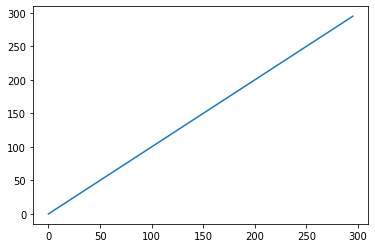

In [91]:
plt.plot(jkam_fpga_matchlist)

In [92]:
# jkam_fpga_matchlist = np.arange(num_shots)
# mask_valid_data=np.ones(num_shots)>0

### Load from red opal kelly

In [93]:
plot_fig = True
start = time.time()

# datastream_name='PhotonTimer'
# working_path = Path.cwd().parent
# data_path_fpga = working_path/'data'/run_name/datastream_name
# file_prefix='PTPhotonTimer'

threshold=2
box=1

frame_num = 0
unit_time_PT = 1/700 #us 

# path, dirs, files = next(os.walk(data_path_fpga))
# num_shot_start = 0
# num_shots_opal = len(files)
# num_shots = num_shots_opal
# num_shots = num_shots_opal


# if override_num_shots:
#     num_shots = num_shots_manual
    
try:
    num_shots_loaded = len(np.load(f'{run_name}_FPGA_timestamp_array_raw.pkl', allow_pickle=True))
except FileNotFoundError:
    num_shots_loaded = 0
    
PT_cavity_photoncount_array=np.zeros((num_shots, num_frames))
PT_cavity_photoncount_array[:] = np.NaN
PT_cavity_photoncount_array_raw=np.zeros((num_shots, num_frames))
PT_cavity_photoncount_array_raw[:] = np.NaN
PT_cavity_timestamp_array_raw = np.empty(num_shots, dtype=object)
#################################################################
if reset_hard:
    print(f'loading {num_shots} shots from PT raw data')

    for shot_num in range(num_shots):
        if shot_num%100 == 0:
            print(f'shot{shot_num} done')
        if mask_valid_data[shot_num]:   
            file_name = fpga_file_prefix+'_'+str(jkam_fpga_matchlist[shot_num]).zfill(5)+'.bin'
            with open(data_path_fpga/file_name, 'rb') as f:

                bin_data = np.unpackbits(np.fromfile(f, dtype=np.uint8))
                # events, events_malformed = te.parse(bin_data) # numba version
    #             print(len(bin_data))
                events, events_malformed = Photontimer.process_timer_py(bin_data) # pure python version
                # print(events[4])
            timestamps = np.sort(events[4])
            PT_cavity_timestamp_array_raw[shot_num]  = unit_time_PT * timestamps
        else:
            PT_cavity_timestamp_array_raw[shot_num] = np.array([0])
    with open(f'{run_name}_FPGA_timestamp_array_raw.pkl','wb') as f1:
         pickle.dump(PT_cavity_timestamp_array_raw, f1)
          
    print('done')
#########################################################################################
else:
    print(f'loading {num_shots_loaded} shots from PT pickle file')
    try:
        PT_cavity_timestamp_array_raw[:num_shots_loaded] = np.load(f'{run_name}_FPGA_timestamp_array_raw.pkl', allow_pickle=True)
        print('done')
    except:
        print('first time run')
    
    if (num_shots > num_shots_loaded):
        print(f'loading {num_shots_loaded} to {num_shots} shots from PT pickle file')
        for shot_num in range(num_shots_loaded, num_shots):
            if shot_num%100 == 0:
                print(f'shot{shot_num} done')
                
            if mask_valid_data[shot_num]:
                file_name = fpga_file_prefix+'_'+str(jkam_fpga_matchlist[shot_num]).zfill(5)+'.bin'
                with open(data_path_fpga/file_name, 'rb') as f:

                    bin_data = np.unpackbits(np.fromfile(f, dtype=np.uint8))
                    # events, events_malformed = te.parse(bin_data) # numba version
        #             print(len(bin_data))
                    events, events_malformed = Photontimer.process_timer_py(bin_data) # pure python version
                    # print(events[4])
                timestamps = np.sort(events[4])
                PT_cavity_timestamp_array_raw[shot_num]  = unit_time_PT * timestamps
            else:
                PT_cavity_timestamp_array_raw[shot_num] = np.array([0])
            
        with open(f'{run_name}_FPGA_timestamp_array_raw.pkl','wb') as f1:
             pickle.dump(PT_cavity_timestamp_array_raw, f1)
          
    print('done')
    
    

print(f"time elapsed {time.time()-start} s")




loading 143 shots from PT pickle file
done
loading 143 to 296 shots from PT pickle file
shot200 done
done
time elapsed 37.598448753356934 s


### Load from silver opal kelly

In [94]:
plot_fig = False

load_silver = False

override_num_shot_silvers= override_num_shots

num_shot_silvers_manual=num_shots_manual

file_read_every=10

if load_silver:

    start = time.time()

    datastream_name='PhotonTimer_Silver'
    working_path = Path.cwd().parent
    data_path_fpga = working_path/'data'/run_name/datastream_name
    file_prefix='PTPhotonTimer_Silver'

    # axialPD_avg_array = np.zeros(num_shot_silvers)
    # axialPD_avg_array[:] = np.NaN
    # axialPD_sigma_array = np.zeros(num_shot_silvers)
    # axialPD_sigma_array[:] = np.NaN
    # step_start = 15000
    # step_end = 25000
    threshold=2
    box=1
    cumulative_file_offset = 0
    frame_num = 0
    unit_time_PT = 1/700 #us


    path, dirs, files = next(os.walk(data_path_fpga))
    # num_shot_silvers = 600
    num_shot_silver_start = 0
    num_shot_silvers_fpga = len(files)
    num_shot_silvers = num_shot_silvers_fpga
    # num_shot_silvers = num_shot_silvers_fpga
    if override_num_shot_silvers:
        num_shot_silvers = num_shot_silvers_manual

    try:
        num_shots_loaded = len(np.load(f'{run_name}_SilverFPGA_timestamp_array_raw.pkl', allow_pickle=True))
    except FileNotFoundError:
        num_shots_loaded = 0

    #################################################################
    if num_shot_silvers != num_shots_loaded or reset_hard:

        print(f'loading {num_shot_silvers} shots from PT raw data')
        PT_cavity_photoncount_array=np.zeros((num_shot_silvers, num_frames))
        PT_cavity_photoncount_array[:] = np.NaN
        PT_cavity_photoncount_array_raw=np.zeros((num_shot_silvers, num_frames))
        PT_cavity_photoncount_array[:] = np.NaN
    #     PT_cavity_timestamp_array = np.empty((num_shot_silvers, num_frames), dtype=object)
        Silver_PT_cavity_timestamp_array_raw = np.empty(num_shot_silvers, dtype=object)

        for shot_num in range(num_shot_silvers):
            if shot_num%100 == 0:
                print(f'shot{shot_num} done')

            file_name = file_prefix+'_'+str(shot_num).zfill(5)+'.bin'
            if (shot_num % file_read_every)==0:
                with open(data_path_fpga/file_name, 'rb') as f:

                    bin_data = np.unpackbits(np.fromfile(f, dtype=np.uint8))
                    # events, events_malformed = te.parse(bin_data) # numba version
        #             print(len(bin_data))
                    events, events_malformed = Photontimer.process_timer_py(bin_data) # pure python version
                    # print(events[4])
            timestamps = np.sort(events[4])
            Silver_PT_cavity_timestamp_array_raw[shot_num-cumulative_file_offset]  = unit_time_PT * timestamps

        with open(f'{run_name}_SilverFPGA_timestamp_array_raw.pkl','wb') as f1:
             pickle.dump(Silver_PT_cavity_timestamp_array_raw, f1)

        print('done')
    #########################################################################################
    else:
        print(f'loading {num_shots_loaded} shots from Silver PT pickle file')
        Silver_PT_cavity_timestamp_array_raw = np.load(f'{run_name}_SilverFPGA_timestamp_array_raw.pkl', allow_pickle=True)
        print('done')


    print(f"time elapsed {time.time()-start} s")

In [95]:
### Haven't updated the file offset correction on the silver opal #TO DO

if load_silver:

    t_prep = 100
    f_sweep_start = -2
    t_sweep = 2e3
    f_sweep_end = 2
    f0_array = np.zeros(num_shot_silvers)
    f0_array[:] = np.NaN
    for shot_num in range(num_shot_silvers):

        try:
            pfs_freq = Silver_PT_cavity_timestamp_array_raw[shot_num] - t_prep
            pfs_freq = f_sweep_start+(pfs_freq/t_sweep)*(f_sweep_end-f_sweep_start)
            bins=20
            bin_time = t_sweep/bins
            n, bins = np.histogram(pfs_freq, bins=bins)

            x_sample = np.arange(f_sweep_start, f_sweep_end, 0.01)
            popt, pcov = curve_fit(E6math.CauchyNoOffset, (bins[1:]+bins[:-1])/2,n/bin_time, p0=(1,1000,0))
        #     print(f'shot#={shot_num}, f0={popt[2]:5.3f}MHz')
            f0_array[shot_num] = popt[2]
        except:
            f0_array[shot_num] = np.nan
        
        if shot_num==0:
            plt.plot((bins[1:]+bins[:-1])/2,n,'o-')
            plt.xlabel('probe_freq_offset_MHz',fontsize=12)
            plt.ylabel('photon counts',fontsize=12)
#     plt.figure(figsize=(10,5))
#     bins=50
#     plt.hist(f0_array, alpha=0.5, color='b', bins=bins)
#     plt.ylabel('occurence')
#     plt.xlabel('delta_PC_zero')

    f0_whole_run = np.nanmean(f0_array)
    print(f'averaged f0 = {f0_whole_run}')

    filtered_f0_array = butter_lowpass_filter(f0_array, cutoff=0.1, order=2)
    slowfiltered_f0_array = butter_lowpass_filter(f0_array, cutoff=0.02, order=2)

    plt.figure(figsize=(10,5))
    bins=50
    plt.plot(np.arange(num_shot_silvers),f0_array)
    plt.plot(np.arange(num_shot_silvers),filtered_f0_array)
    plt.plot(np.arange(num_shot_silvers),slowfiltered_f0_array)
    plt.xlabel('shot#')
    plt.ylabel('delta_PC_zero')
#     plt.ylim(-5,5)
#     plt.xlim(-5,5)

### ROI user input and load JKAM data

In [96]:
roi_width = 16
roi_height = 16
roi_area = roi_width * roi_width

def roi_center(tweezer_freq):
    center_x = round(2 * (0.01 * (tweezer_freq - 108)**2+ 26.8 * (tweezer_freq - 100) + 422)) / 2
    center_y = round(2 * (-0.5 * (tweezer_freq - 100) + 30)) / 2
    return [center_x, center_y]

def roi_slice_func(tweezer_freq):
    center_x = roi_center(tweezer_freq)[0]
    center_y = roi_center(tweezer_freq)[1]
    return tuple((slice(round(center_y - roi_height / 2), round(center_y + roi_height / 2), 1), \
                  slice(round(center_x - roi_width / 2), round(center_x + roi_width / 2), 1)))

start = time.time()

quiet = False
plot_true = False
datastream_name='High NA Imaging' 
working_path = Path.cwd().parent
data_path = working_path/'data'/run_name/datastream_name
file_prefix='jkam_capture'

path, dirs, files = next(os.walk(data_path))
# num_shots = 600
num_shot_start = 0


# cells array for raw images
# image_array = [[[None for _ in range(num_tweezers)] for _ in range(num_frames)] for _ in range(num_shots)]

if override_num_shots:
    num_shots = num_shots_manual
try:
    num_shots_loaded = len(np.load(f'{run_name}_jkam_counts_array.pkl', allow_pickle=True))
except FileNotFoundError:
    num_shots_loaded = 0
    

if num_shots != num_shots_loaded or reset_hard:
    print(f'loading {num_shots} shots from raw data')
    counts_array = np.empty([num_shots, num_frames, num_tweezers])
    frames_array = np.zeros([num_frames,80,1100])
#     image_array = [[[None for _ in range(num_tweezers)] for _ in range(num_frames)] for _ in range(num_shots)]
    for shot_num in range(num_shot_start, num_shot_start+num_shots):
        if quiet == False and shot_num%1000 == 0: 
            print(f'shot_num={shot_num}')

        file_name = file_prefix+'_'+str(shot_num).zfill(5)+'.h5'
        hf = h5py.File(data_path/file_name, 'r')
        point = shot_num % num_points
        for frame_num in range(num_frames):
            photo = np.array(hf.get('frame-'+str(frame_num+1).zfill(2)))
            tweezer_freq_counter = 0     
            for tweezer_freq in tweezer_freq_list:
#                 image_array[shot_num-num_shot_start][frame_num][tweezer_freq_counter]= np.array(photo[roi_slice_func(tweezer_freq)],dtype='int32')
                counts_array[shot_num-num_shot_start, frame_num, tweezer_freq_counter] = np.sum(photo[roi_slice_func(tweezer_freq)])
                tweezer_freq_counter += 1

            frames_array[frame_num] += photo

            if plot_true == False: 
                if frame_num == 5:
                    vmin = 105
                    vmax = 140

                    fig,ax = plt.subplots(1, 1,figsize=(10, 10) )
                    ax.imshow(photo, norm = colors.Normalize(vmin=vmin,vmax=vmax), cmap='hot', interpolation='nearest')
                    for tweezer_freq in tweezer_freq_list:
                        rect1 = patches.Rectangle((round(roi_center(tweezer_freq)[0] - roi_width/2),round(roi_center(tweezer_freq)[1] - roi_height/2)), roi_width,roi_height,linewidth=1,edgecolor='white',facecolor='none')
                        ax.add_patch(rect1)
                    plt.show()
                    print(counts_array[shot_num-num_shot_start, frame_num])

        hf.close
    frames_array = frames_array/num_shots*num_points
    
    with open(f'{run_name}_jkam_counts_array.pkl','wb') as f1:
         pickle.dump(counts_array, f1)
    with open(f'{run_name}_jkam_frames_array.pkl','wb') as f2:
         pickle.dump(frames_array, f2)
#     with open(f'{run_name}_jkam_images_array.pkl','wb') as f3:
#          pickle.dump(image_array, f3)
            
    print('done')
else:
    print(f'loading { num_shots_loaded} shots from pickle file')
    counts_array = np.load(f'{run_name}_jkam_counts_array.pkl', allow_pickle=True)
    frames_array = np.load(f'{run_name}_jkam_frames_array.pkl', allow_pickle=True)
#     image_array = np.load(f'{run_name}_jkam_images_array.pkl', allow_pickle=True)
    print('done')

print(f"time elapsed {time.time()-start} s")

loading 296 shots from raw data
shot_num=0
done
time elapsed 16.84786105155945 s


### load from GaGe scope

In [97]:
reset_gage = reset_hard
# reset_gage = True
time_me = True
plot_tenth_shot = True
het_freq = 20.000446 #MHz
# het_freq = 20.000 #MHz
dds_freq = het_freq/2
samp_freq = 200 #MHz
# averaging_time = 100 #us
# step_time = 5 #us
# filter_time = 10 #us
step_time = 50 #us
filter_time = 100 #us
voltage_conversion = 1000/32768 #in units of mV
kappa = 2*np.pi * 1.1 #MHz
LO_power = 314 #uW
PHOTON_ENERGY = 2.55e-19
LO_rate = 1e-12 * LO_power / PHOTON_ENERGY # count/us
photonrate_conversion = 1e-6/(2e7)/ PHOTON_ENERGY / (0.5*0.8) # count/us
#2e7 is the conversion gain, 2.55e-19 is single photon energy, the rest is the path efficiency
heterodyne_conversion = 1/np.sqrt(LO_rate) # np.sqrt(count/us)
cavity_conversion = 1/np.sqrt(kappa)
conversion_factor = voltage_conversion*photonrate_conversion*heterodyne_conversion*cavity_conversion
# filter_type = "square"
datastream_name_gage='gage'
working_path_gage = Path.cwd().parent
data_path_gage = working_path_gage/'data'/run_name/datastream_name_gage
file_prefix_gage = 'gage_shot'
path, dirs, files = next(os.walk(data_path_gage))
num_shot_gage_start = 0
num_shots_gage = len(files)
if override_num_shots:
    num_shots_gage = num_shots_manual
    
start = time.time()
try:
    num_shots_loaded = np.load(f'{run_name}_gage_cmplx_amp_{filter_time}_{step_time}.pkl', allow_pickle=True).shape[1]
except FileNotFoundError:
    num_shots_loaded = 0
try:
    np.load(f'{run_name}_gage_timebin_{filter_time}_{step_time}.pkl', allow_pickle=True)
except FileNotFoundError:
    num_shots_loaded = 0
if time_me:
    file_reading_time = 0
    inner_product_time = 0
    now = start
#################################################################
if reset_gage:
#     path, dirs, files = next(os.walk(data_path_gage))
#     num_shot_gage_start = 0
#     num_shots_gage = len(files)
# #     num_shots = num_shots_gage
#     if override_num_shots:
#         num_shots_gage = num_shots_manual
    print(f'Hard reset, loading {num_shots_gage} shots from gage raw data')
    file_name_gage = file_prefix_gage+'_00000.h5'
    hf = h5py.File(data_path_gage/file_name_gage, 'r')
    chlen = len(np.array(hf.get('CH1')))
    t_vec = np.arange(chlen)*1/samp_freq
    ch1_pure_vec = np.exp(-1j*2*np.pi * dds_freq*t_vec)
    ch3_pure_vec = np.exp(-1j*2*np.pi * het_freq*t_vec)
#                 t0_list=np.linspace(0,len(ch1)/samp_freq-filter_time,int(len(ch1)/samp_freq/step_time))
    t0_list = np.arange(0,chlen/samp_freq-filter_time+step_time,step_time)
    timebin_array = np.empty((len(t0_list),2), dtype=float)
    timebin_array[:,0] = t0_list
    timebin_array[:,1] = t0_list + filter_time
    cmplx_amp_array = np.empty((2, num_shots_gage,len(t0_list)), dtype=np.cdouble)
    t0_idx_list = np.arange(0,chlen-filter_time*samp_freq+1,step_time*samp_freq)
#     t1_idx_list = t0_idx_list + filter_time*samp_freq
    for shot_num in range(num_shots_gage):
        if shot_num%100 == 0:
            print(f'shot{shot_num} done')
        if True: #mask_valid_data[shot_num]:
            file_name_gage = file_prefix_gage+'_'+str(shot_num).zfill(5)+'.h5'
            hf = h5py.File(data_path_gage/file_name_gage, 'r')
#             ch1 = np.array(hf.get('CH1')) * voltage_conversion
#             ch3 = np.array(hf.get('CH3')) * voltage_conversion
            ch1 = np.array(hf['CH1']) * conversion_factor #np.sqrt(n)
            ch3 = np.array(hf['CH3']) * conversion_factor #np.sqrt(n)
            if time_me:
                file_reading_time += time.time() - now
                now = time.time()
            ch1_demod = np.multiply(ch1 , ch1_pure_vec) # * 1j
            ch3_demod = np.multiply(ch3 , ch3_pure_vec) # * 1j
            ch1_demod_sum = np.concatenate([[0],np.cumsum(ch1_demod)])
            ch3_demod_sum = np.concatenate([[0],np.cumsum(ch3_demod)])
            cmplx_amp_list_ch1=t0_list*0j
            cmplx_amp_list_ch3=t0_list*0j
            for i,t0_idx in enumerate(t0_idx_list):
                t1_idx = t0_idx + filter_time*samp_freq
#                 cmplx_amp_list_ch1[i] = np.mean(ch1_demod[t0_idx:t1_idx])
#                 cmplx_amp_list_ch3[i] = np.mean(ch3_demod[t0_idx:t1_idx])
                cmplx_amp_list_ch1[i] = (ch1_demod_sum[t1_idx] - ch1_demod_sum[t0_idx]) / (t1_idx-t0_idx)
                cmplx_amp_list_ch3[i] = (ch3_demod_sum[t1_idx] - ch3_demod_sum[t0_idx]) / (t1_idx-t0_idx)
            if time_me:
                inner_product_time += time.time() - now
                now = time.time()
            cmplx_amp_array[0, shot_num] = cmplx_amp_list_ch1
            cmplx_amp_array[1, shot_num] = cmplx_amp_list_ch3
            if plot_tenth_shot and shot_num == 50:
                t_start = 200
                amp_list_ch1 = abs(cmplx_amp_list_ch1)
                angle_list_ch1 = np.angle(cmplx_amp_list_ch1)%(2*np.pi)
                amp_list_ch3 = abs(cmplx_amp_list_ch3)
                angle_list_ch3 = np.angle(cmplx_amp_list_ch3)%(2*np.pi)
                fig, (ax1, ax2)  = plt.subplots(1, 2, figsize=(16,5))
                ax1.plot(np.arange(0,filter_time,1/samp_freq), ch1[0:filter_time*samp_freq])
                ax2.plot(np.arange(0,filter_time,1/samp_freq), ch3[0:filter_time*samp_freq])
                ax1.set_ylabel("mV")
                ax2.set_ylabel("mV")
                plt.show()
                fig, (ax1, ax2)  = plt.subplots(1, 2, figsize=(16,5))
                ax1.plot(t0_list,(2*np.unwrap(angle_list_ch1)))
                ax1.plot(t0_list,np.unwrap(angle_list_ch3))
                ax2.plot(t0_list,amp_list_ch1)
                ax2.plot(t0_list,amp_list_ch3)
                ax1.set_xlabel("us")
                ax2.set_xlabel("us")
                plt.show()
        else:
            cmplx_amp_array[:, shot_num, :] = np.array([np.nan])
    with open(f'{run_name}_gage_cmplx_amp_{filter_time}_{step_time}.pkl','wb') as f1:
         pickle.dump(cmplx_amp_array, f1)
    with open(f'{run_name}_gage_timebin_{filter_time}_{step_time}.pkl','wb') as f3:
         pickle.dump(timebin_array, f3)
    print('done')
    if time_me:
        print(f"file_reading_time = {file_reading_time} s")
        print(f"inner_product_time = {inner_product_time} s")
####################################################################
else:
    print(f'loading {num_shots_loaded} shots from gage pickle files')
    try:
        cmplx_amp_array_old = np.load(f'{run_name}_gage_cmplx_amp_{filter_time}_{step_time}.pkl', allow_pickle=True)
        timebin_array = np.load(f'{run_name}_gage_timebin_{filter_time}_{step_time}.pkl', allow_pickle=True)
    except:
        print('first time run')
#         path, dirs, files = next(os.walk(data_path_gage))
#         num_shots_gage = len(files)
#         if override_num_shots:
#             num_shots_gage = num_shots_manual
####################################################################
    if (num_shots_gage > num_shots_loaded):
        print(f'loading {num_shots_loaded} to {num_shots_gage} shots from gage raw data')
        file_name_gage = file_prefix_gage+'_00000.h5'
        hf = h5py.File(data_path_gage/file_name_gage, 'r')
        chlen = len(np.array(hf.get('CH1')))
        t_vec = np.arange(chlen)*1/samp_freq
        ch1_pure_vec = np.exp(-1j*2*np.pi * dds_freq*t_vec)
        ch3_pure_vec = np.exp(-1j*2*np.pi * het_freq*t_vec)
    #                 t0_list=np.linspace(0,len(ch1)/samp_freq-filter_time,int(len(ch1)/samp_freq/step_time))
        t0_list = np.arange(0,chlen/samp_freq-filter_time+step_time,step_time)
        timebin_array = np.empty((len(t0_list),2), dtype=float)
        timebin_array[:,0] = t0_list
        timebin_array[:,1] = t0_list + filter_time
        cmplx_amp_array = np.empty((2, num_shots_gage,len(t0_list)), dtype=np.cdouble)
        if num_shots_loaded > 0:
            cmplx_amp_array[:,0:num_shots_loaded,:] = cmplx_amp_array_old
        t0_idx_list = np.arange(0,chlen-filter_time*samp_freq+1,step_time*samp_freq)
    #     t1_idx_list = t0_idx_list + filter_time*samp_freq
        for shot_num in range(num_shots_loaded, num_shots_gage):
            if shot_num%100 == 0:
                print(f'shot{shot_num} done')
            if True:
                file_name_gage = file_prefix_gage+'_'+str(shot_num).zfill(5)+'.h5'
                hf = h5py.File(data_path_gage/file_name_gage, 'r')
    #             ch1 = np.array(hf.get('CH1')) * voltage_conversion
    #             ch3 = np.array(hf.get('CH3')) * voltage_conversion
                ch1 = np.array(hf['CH1']) * conversion_factor
                ch3 = np.array(hf['CH3']) * conversion_factor
                if time_me:
                    file_reading_time += time.time() - now
                    now = time.time()
                ch1_demod = np.multiply(ch1 , ch1_pure_vec) # * 1j
                ch3_demod = np.multiply(ch3 , ch3_pure_vec) # * 1j
                ch1_demod_sum = np.concatenate([[0],np.cumsum(ch1_demod)])
                ch3_demod_sum = np.concatenate([[0],np.cumsum(ch3_demod)])
                cmplx_amp_list_ch1=t0_list*0j
                cmplx_amp_list_ch3=t0_list*0j
                for i,t0_idx in enumerate(t0_idx_list):
                    t1_idx = t0_idx + filter_time*samp_freq
                    cmplx_amp_list_ch1[i] = (ch1_demod_sum[t1_idx] - ch1_demod_sum[t0_idx]) / (t1_idx-t0_idx)
                    cmplx_amp_list_ch3[i] = (ch3_demod_sum[t1_idx] - ch3_demod_sum[t0_idx]) / (t1_idx-t0_idx)
                if time_me:
                    inner_product_time += time.time() - now
                    now = time.time()
                cmplx_amp_array[0, shot_num] = cmplx_amp_list_ch1
                cmplx_amp_array[1, shot_num] = cmplx_amp_list_ch3
#                 if plot_tenth_shot and shot_num == 10:
#                     t_start = 200
#                     amp_list_ch1 = abs(cmplx_amp_list_ch1)
#                     angle_list_ch1 = np.angle(cmplx_amp_list_ch1)%(2*np.pi)
#                     amp_list_ch3 = abs(cmplx_amp_list_ch3)
#                     angle_list_ch3 = np.angle(cmplx_amp_list_ch3)%(2*np.pi)
#                     fig, (ax1, ax2)  = plt.subplots(1, 2, figsize=(16,5))
#                     ax1.plot(np.arange(0,filter_time,1/samp_freq), ch1[0:filter_time*samp_freq])
#                     ax2.plot(np.arange(0,filter_time,1/samp_freq), ch3[0:filter_time*samp_freq])
#                     ax1.set_ylabel("mV")
#                     ax2.set_ylabel("mV")
#                     plt.show()
#                     fig, (ax1, ax2)  = plt.subplots(1, 2, figsize=(16,5))
#                     ax1.plot(t0_list,(2*np.unwrap(angle_list_ch1)))
#                     ax1.plot(t0_list,np.unwrap(angle_list_ch3))
#                     ax2.plot(t0_list,amp_list_ch1)
#                     ax2.plot(t0_list,amp_list_ch3)
#                     ax1.set_xlabel("us")
#                     ax2.set_xlabel("us")
#                     plt.show()
            else:
                cmplx_amp_array[:, shot_num, :] = np.array([np.nan])
        with open(f'{run_name}_gage_cmplx_amp_{filter_time}_{step_time}.pkl','wb') as f1:
             pickle.dump(cmplx_amp_array, f1)
        with open(f'{run_name}_gage_timebin_{filter_time}_{step_time}.pkl','wb') as f3:
             pickle.dump(timebin_array, f3)
        print('done')
    else:
        cmplx_amp_array=cmplx_amp_array_old
####################################################################
print(f"number of {num_shots_gage} shots loaded")
print(f"total time elapsed {time.time()-start} s")

loading 148 shots from gage pickle files
loading 148 to 306 shots from gage raw data
shot200 done
shot300 done
done
number of 306 shots loaded
total time elapsed 51.076425075531006 s


### Load from position feedback RedPitaya

In [98]:
# cav_contrast[:,1]

In [99]:
# datastream_name='Redpitaya'
# working_path = Path.cwd().parent
# data_path = working_path/'data'/run_name/datastream_name

# cav_contrast = np.loadtxt(data_path/"cnstcav.txt", dtype=float, delimiter=',')
# perp_contrast = np.loadtxt(data_path/"cnstperp.txt", dtype=float, delimiter=',')
# cav_hist = np.loadtxt(data_path/"histcav.txt", dtype=float, delimiter=',')
# perp_hist = np.loadtxt(data_path/"histperp.txt", dtype=float, delimiter=',')
# cav_len = np.loadtxt(data_path/"lencav.txt", dtype=float, delimiter=',')
# perp_len = np.loadtxt(data_path/"lenperp.txt", dtype=float, delimiter=',')
# cav_output = np.loadtxt(data_path/"outcav.txt", dtype=float, delimiter=',')
# perp_output = np.loadtxt(data_path/"outperp.txt", dtype=float, delimiter=',')
# cav_phase = np.loadtxt(data_path/"phicav.txt", dtype=float, delimiter=',')
# perp_phase = np.loadtxt(data_path/"phiperp.txt", dtype=float, delimiter=',')

In [100]:
# plt.figure(figsize=(16,6))
# plt.plot(cav_phase[:,1],label="cav_phase(locked)")
# plt.plot(perp_phase[:,1],label="perp_phase(locked)")
# plt.axhline(0.05,c='k')
# plt.axhline(-0.05,c='k')
# plt.axvline(num_shot_start,c='k')
# plt.xlim(0,500)
# plt.axvline(num_shot_start,c='k')
# plt.legend()

In [101]:
# num_shot_start = 0

# mask_TPF = abs(cav_phase[num_shot_start:])<0.081

# cav_score = len(cav_phase[:,1][num_shot_start:][abs(cav_phase[:,1][num_shot_start:])<0.081])/len(cav_phase[:,1][num_shot_start:])
# perp_score = len(perp_phase[:,1][num_shot_start:][abs(perp_phase[:,1][num_shot_start:])<0.081])/len(perp_phase[:,1][num_shot_start:])

# fig,axs=plt.subplots(ncols=2,nrows=2,figsize=[14,10])

# fig.suptitle(f'{run_name}, cav score = {cav_score:.3f}, perp score = {perp_score:.3f}',fontsize=18)

# plt.sca(axs[0,0])
# plt.plot(cav_len[:,0],cav_len[:,1],label="cav_len(locked)")
# plt.plot(perp_len[:,0],perp_len[:,1],label="perp_len(locked)")
# # plt.ylim(0,1)
# plt.legend()

# plt.sca(axs[0,1])
# plt.plot(cav_contrast[:,0],cav_contrast[:,1],label="cav_contrast(locked)")
# plt.plot(perp_contrast[:,0],perp_contrast[:,1],label="perp_contrast(locked)")
# plt.ylim(0,1)
# plt.legend()

# plt.sca(axs[1,0])
# plt.plot(cav_output[:,0],cav_output[:,1],label="cav_out(locked)")
# plt.plot(perp_output[:,0],perp_output[:,1],label="perp_out(locked)")
# plt.ylim(-1.2,1.2)
# plt.legend()

# plt.sca(axs[1,1])
# plt.plot(cav_phase[:,0],cav_phase[:,1],label="cav_phase(locked)")
# plt.plot(perp_phase[:,0],perp_phase[:,1],label="perp_phase(locked)")
# plt.axhline(0.075,c='k')
# plt.axhline(-0.075,c='k')
# plt.axvline(cav_phase[num_shot_start,0],c='k')
# plt.legend()

## Select data

##### User input section

[550. 550. 550. 550. 550. 550. 550. 550. 550. 550. 550. 550. 550. 550.
 550. 550. 550. 550. 550. 550. 550. 550. 550. 550. 550. 550. 550. 550.
 550. 550. 550. 550. 550. 550. 550. 550. 550. 550. 550. 550.]


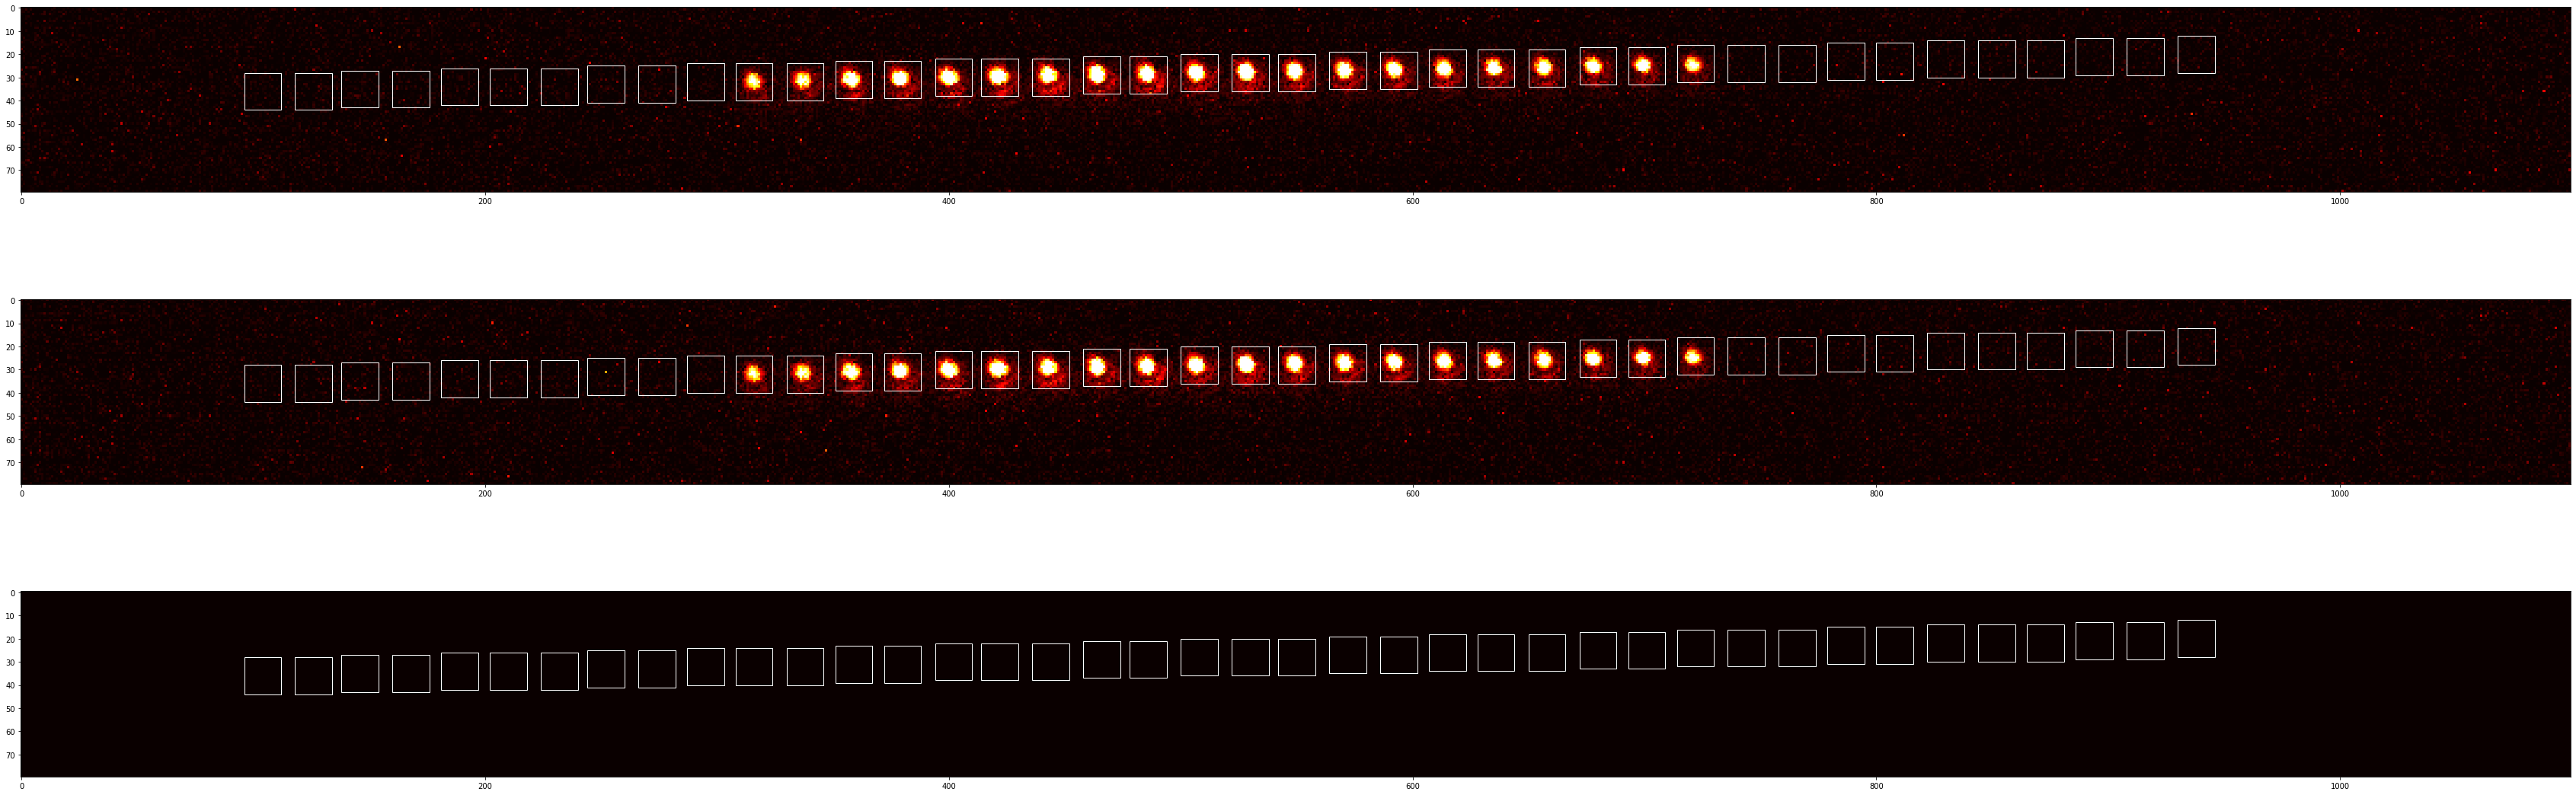

In [102]:
########################### User input section ############################

#Boolean input
###############################################
post_select_true = False
realtime_frequency_zeroing = True
quiet = False
probe_trim = False
odt_freq_center_override = True
plot_many_figures = True
plot_sigma_of_mean = False
###############################################
if plot_sigma_of_mean:
    divider = np.sqrt(num_loops)
else:
    divider = 1


#number input
###############################################
num_start = 0 # This has to be an integer times num_points
num_end = num_shots
num_shots_sliced = num_end - num_start
# num_end = 5000
t_probe_trim = 50 #us #only applied when probe_trim = True
dark_count_threshold=-1
odt_freq_center = -2 #only applied when odt_freq_center_override = True
cav_dark_threshold = 1.5

num_frames_cav_per_twz = 3
t_pre = 200 #us
t_cav_frame = 4.7e3 #44.4e3 #us
t_cav_expo = 2e3 #44.4e3 #us
t_gap = 0

# for the software gate
N_cycle=num_frames_cav_per_twz
t_cycle=t_cav_frame #1.97e3
t_probe=t_cav_expo #0.25e3
t_probe_het=t_cav_expo-filter_time
###############################################

# num_frames_cav = tweezer_num * num_frames_cav_per_twz
num_frames_cav = 1 * num_frames_cav_per_twz
t_cav_start=np.array([t_pre+i*t_cav_frame for i in range(num_frames_cav_per_twz)] +\
            [t_pre+(3+i)*t_cav_frame+t_gap for i in range(num_frames_cav_per_twz)])
# t_cav_start=np.array([t_pre,t_pre+t_cav_expo,t_pre+2*t_cav_expo,t_pre+3*t_cav_expo+t_gap,t_pre+4*t_cav_expo+t_gap,t_pre+5*t_cav_expo+t_gap])
t_cav_end = t_cav_start + t_cav_expo


#list input
###############################################
upper_threshold_list_F0 = 550*np.ones(num_tweezers)
# upper_threshold_list_F0[0] = 550
print(upper_threshold_list_F0)
# upper_threshold_list_F0 = [300,300,400,400,400,400,400,400,400,400,400,400,250,250] # counts above ref shot for each tweezer for frame 0
upper_threshold_list_F1 = 550*np.ones(num_tweezers) # counts above ref shot for each tweezer for frame 1
# upper_threshold_list_F1[0] = 400

upper_threshold_list_F2 = upper_threshold_list_F0 # counts above ref shot for each tweezer for frame 2
upper_threshold_list_F3 = upper_threshold_list_F0
upper_threshold_list_F4 = upper_threshold_list_F0
upper_threshold_list = upper_threshold_list_F0
###############################################
upper_threshold_mat=[upper_threshold_list_F0,upper_threshold_list_F1,upper_threshold_list_F2, upper_threshold_list_F3, upper_threshold_list_F4]


###########################################################################################################

import matplotlib.patches as patches
fig, axs = plt.subplots(num_frames, 1 ,figsize=(60, 20))
for frame_num in range(num_frames):
    axs[ frame_num].imshow(frames_array[frame_num]-frames_array[-1], cmap='hot', interpolation='nearest')
    for tweezer_freq in tweezer_freq_list:
        rect1 = patches.Rectangle((round(roi_center(tweezer_freq)[0] - roi_width/2),round(roi_center(tweezer_freq)[1] - roi_height/2)), roi_width,roi_height,linewidth=1,edgecolor='white',facecolor='none')
        axs[ frame_num].add_patch(rect1)
        
for axt in axs:        
    for im in axt.get_images():
        im.set_clim(0, 90)

plt.show()

### High NA imaging and cavity photoncount

In [103]:


# survival = np.zeros((num_points, num_frames,tweezer_num))

atom_existence_array = np.zeros((num_shots_sliced, num_frames, num_tweezers))


atom_brightness_array = np.zeros((num_shots_sliced, num_frames, num_tweezers))
for tweezer_counter,tweezer in enumerate(tweezer_freq_list):
    for j in range(num_frames-1):
#         atom_brightness_array[:,j,tweezer_counter] = counts_array[num_start:num_end,j,tweezer_counter] - np.mean(counts_array[num_start:num_end,-1,tweezer_counter])
        atom_brightness_array[:,j,tweezer_counter] = counts_array[num_start:num_end,j,tweezer_counter] - counts_array[num_start:num_end,-1,tweezer_counter]

        
for shot_num in range(num_shots_sliced):
    for tweezer_counter, tweezer in enumerate(tweezer_freq_list):
        for frame_num in range(num_frames):
            if (atom_brightness_array[shot_num, frame_num, tweezer_counter] > upper_threshold_mat[frame_num][tweezer_counter]):
                atom_existence_array[shot_num, frame_num, tweezer_counter] = 1        
        
        
mask_all = np.zeros((num_shots_sliced, num_frames))

mask_num_atoms_list = []
for n in range(num_tweezers):
    mask = np.empty((num_shots_sliced, num_frames))
    mask[:] = np.NaN
    mask_num_atoms_list.append(mask)
mask_num_atoms_list = np.array(mask_num_atoms_list)
# #################################################################################                              

# for frame_num in range(num_frames):
#     mask00[:,frame_num]=(atom_brightness_array[:,frame_num,atom_site[frame_num][0]] < upper_threshold_mat[frame_num][0]) & (atom_brightness_array[:,frame_num,atom_site[frame_num][1]] < upper_threshold_mat[frame_num][1])
#     mask10[:,frame_num]=(atom_brightness_array[:,frame_num,atom_site[frame_num][0]] >= upper_threshold_mat[frame_num][0]) & (atom_brightness_array[:,frame_num,atom_site[frame_num][1]] < upper_threshold_mat[frame_num][1])
#     mask01[:,frame_num]=(atom_brightness_array[:,frame_num,atom_site[frame_num][0]] < upper_threshold_mat[frame_num][0]) & (atom_brightness_array[:,frame_num,atom_site[frame_num][1]] >= upper_threshold_mat[frame_num][1])        
#     mask11[:,frame_num]=(atom_brightness_array[:,frame_num,atom_site[frame_num][0]] >= upper_threshold_mat[frame_num][0]) & (atom_brightness_array[:,frame_num,atom_site[frame_num][1]] >= upper_threshold_mat[frame_num][1])
    

for shot_num in range(num_shots_sliced):
    for frame_num in range(num_frames):    
        for twz in range(num_tweezers):
            if atom_brightness_array[shot_num,frame_num,atom_site[frame_num][twz]] >= upper_threshold_mat[frame_num][twz]:
                mask_all[shot_num,frame_num] = 1

                
# calculate an mask of atom number 1-num_tweezers
for shot_num in range(num_shots_sliced):
    for frame_num in range(num_frames):    
        for num_atoms in range(num_tweezers):
            mask_num_atoms_list[num_atoms][shot_num, frame_num] = (int(np.sum(atom_existence_array[shot_num, frame_num,:])) == num_atoms + 1)
#             if int(np.sum(atom_existence_array[shot_num, frame_num,:])) == num_atoms + 1:
#                 mask_num_atoms_list[num_atoms][shot_num, frame_num] = 1



In [104]:
atom_brightness_point_list = []
    
for point in range(num_points):
    atom_brightness_point_list.append(atom_brightness_array[point::num_points])

atom_brightness_point_array = np.array(atom_brightness_point_list)

point_survival = np.zeros((num_points, num_tweezers))
point_survival_err = np.zeros((num_points, num_tweezers))
point_survival_1 = np.zeros(num_points)
point_survival_1_err = np.zeros(num_points)

for point in range(num_points):
    survival_sum = 0
    total_atoms = 0
    for tweezer_num in range(num_tweezers):
        survival_list = []
        for shot_num in range(len(atom_brightness_point_array[point])):
            if ( (atom_brightness_point_array[point][shot_num][0][tweezer_num] >= upper_threshold_mat[0][tweezer_num]) and (atom_brightness_point_array[point][shot_num][1][tweezer_num] >= upper_threshold_mat[1][tweezer_num]) ):
                survival_list.append(1)
            elif ( (atom_brightness_point_array[point][shot_num][0][tweezer_num] >= upper_threshold_mat[0][tweezer_num]) and (atom_brightness_point_array[point][shot_num][1][tweezer_num] < upper_threshold_mat[1][tweezer_num]) ): 
                survival_list.append(0)
#         print(survival_list)
        point_survival[point, tweezer_num] = np.sum(survival_list)/len(survival_list)
        point_survival_err[point,tweezer_num] = np.sqrt(point_survival[point,tweezer_num]*(1-point_survival[point,tweezer_num])/len(survival_list))
        survival_sum += np.sum(survival_list)
        total_atoms += len(survival_list)
            
    point_survival_1[point] = survival_sum/total_atoms
    point_survival_1_err[point] = np.sqrt(point_survival_1[point]*(1-point_survival_1[point])/total_atoms)


C:\Users\Microscope\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  
C:\Users\Microscope\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars


C:\Users\Microscope\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\axes\_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
C:\Users\Microscope\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\axes\_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
C:\Users\Microscope\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\axes\_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
C:\Users\Microscope\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\axes\_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
C:\Users\Microscope\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\axes\_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
C:\Users\Microscope\AppData\Local\Programs\Python\

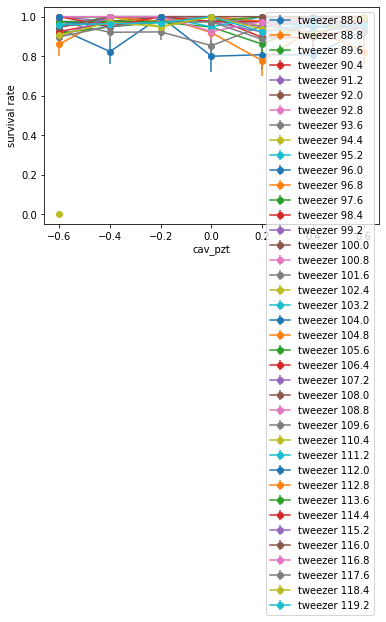

In [105]:
for tweezer in range(num_tweezers):
    plt.errorbar(point_list, point_survival[:,tweezer], point_survival_err[:,tweezer], label=f'tweezer {tweezer_freq_list[tweezer].round(3)}',
                marker='o')


plt.xlabel(point_name_inner)
plt.ylabel('survival rate')
plt.legend()

Text(0, 0.5, 'avg survival rate')

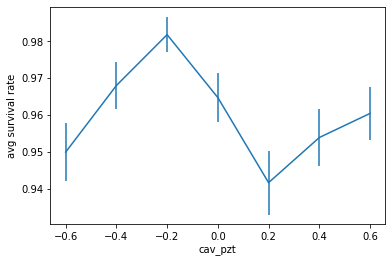

In [106]:
plt.errorbar(point_list, point_survival_1, point_survival_1_err)
plt.xlabel(point_name_inner)
plt.ylabel(f'avg survival rate')

survival rates: [       nan        nan        nan        nan        nan 1.
 1.                nan 0.         1.         0.87677725 0.90638298
 0.9379845  0.94296578 0.96678967 0.9676259  0.97769517 0.92882562
 0.96875    0.97080292 0.96478873 0.99305556 0.98611111 0.97894737
 0.97849462 0.99272727 0.97482014 0.93656716 0.9561753  0.96464646
 1.                nan        nan        nan        nan        nan
        nan        nan 1.                nan]
survival error: [       nan        nan        nan        nan        nan 0.
 0.                nan 0.         0.         0.02262814 0.019002
 0.01501544 0.01430006 0.01088474 0.01061525 0.00900378 0.01533825
 0.01025261 0.01017091 0.01093699 0.00489338 0.00689605 0.00850375
 0.00868462 0.00512386 0.00939651 0.01488878 0.01292086 0.01312405
 0.                nan        nan        nan        nan        nan
        nan        nan 0.                nan]


C:\Users\Microscope\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Microscope\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice
C:\Users\Microscope\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\lib\nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


Text(0, 0.5, 'Event Probability')

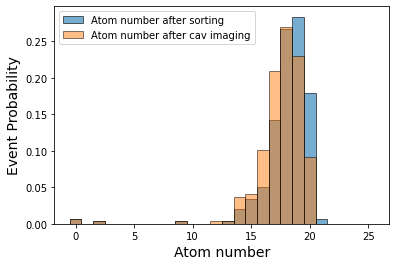

In [107]:
survival = np.zeros(num_tweezers)
survival[:]=np.nan
survival_err = np.zeros(num_tweezers)
survival_err[:]=np.nan

brightness = np.zeros(num_tweezers)
brightness[:]=np.nan
brightness_err = np.zeros(num_tweezers)
brightness_err[:]=np.nan




# atom_brightness_array = np.zeros((num_shots_sliced, num_frames, num_tweezers))
# for tweezer_counter,tweezer in enumerate(tweezer_freq_list):
#     for j in range(num_frames-1):
#         atom_brightness_array[:,j,tweezer_counter] = counts_array[num_start:num_end,j,tweezer_counter] - np.mean(counts_array[num_start:num_end,-1,tweezer_counter])



for tweezer_counter, tweezer in enumerate(tweezer_freq_list):
    mask_temp = np.logical_and((atom_existence_array[:, 0, tweezer_counter] == 1),(atom_existence_array[:, 1, tweezer_counter] == 1))
    survival[tweezer_counter] = np.count_nonzero(mask_temp)
    survival[tweezer_counter] = survival[tweezer_counter]/np.sum(atom_existence_array[:,0,tweezer_counter])
    survival_err[tweezer_counter] = np.sqrt(survival[tweezer_counter]*(1-survival[tweezer_counter])/np.sum(atom_existence_array[:,0,tweezer_counter]))
    
    
    brightness[tweezer_counter] = np.nanmean(atom_brightness_array[:,0,tweezer_counter][mask_temp])
    brightness_err[tweezer_counter] = np.nanstd(atom_brightness_array[:,0,tweezer_counter][mask_temp])
    
            
            
print(f'survival rates: {survival}')
print(f'survival error: {survival_err}')

# atom number
atom_number=np.sum(atom_existence_array[:,:,:],axis=2)


hist_atom_edge=np.arange(-0.5,25.5+1)
hist_atom_x=(hist_atom_edge[:-1]+hist_atom_edge[1:])/2

hist_atom_0= np.histogram(atom_number[:,0],bins=hist_atom_edge)[0] 
P_atom_0=hist_atom_0/len(atom_number[:,0])

hist_atom_1= np.histogram(atom_number[:,1],bins=hist_atom_edge)[0] 
P_atom_1=hist_atom_1/len(atom_number[:,1])

plt.bar(hist_atom_x,P_atom_0,1, edgecolor="black",facecolor='C0',alpha=0.6,label='Atom number after sorting')
plt.bar(hist_atom_x,P_atom_1,1, edgecolor="black",facecolor='C1',alpha=0.5,label='Atom number after cav imaging')
plt.legend(fontsize=10,loc=2)
plt.xlabel('Atom number', fontsize=14)
plt.ylabel('Event Probability', fontsize=14)


Twz0 Loading rate 0.00, survival rate nan, brightness nan
Twz1 Loading rate 0.00, survival rate nan, brightness nan
Twz2 Loading rate 0.00, survival rate nan, brightness nan
Twz3 Loading rate 0.00, survival rate nan, brightness nan
Twz4 Loading rate 0.00, survival rate nan, brightness nan
Twz5 Loading rate 0.00, survival rate 1.00, brightness 648.00
Twz6 Loading rate 0.00, survival rate 1.00, brightness 920.00
Twz7 Loading rate 0.00, survival rate nan, brightness nan
Twz8 Loading rate 0.00, survival rate 0.00, brightness nan
Twz9 Loading rate 0.01, survival rate 1.00, brightness 770.67
Twz10 Loading rate 0.71, survival rate 0.88, brightness 822.91
Twz11 Loading rate 0.79, survival rate 0.91, brightness 841.11
Twz12 Loading rate 0.87, survival rate 0.94, brightness 950.84
Twz13 Loading rate 0.89, survival rate 0.94, brightness 1011.92
Twz14 Loading rate 0.92, survival rate 0.97, brightness 995.68
Twz15 Loading rate 0.94, survival rate 0.97, brightness 1109.25
Twz16 Loading rate 0.91, su

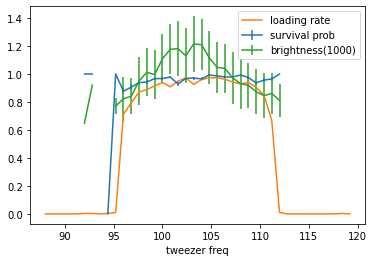

In [108]:
mask_atom_mat = atom_existence_array[:, 0,:]>0.1
mask_atom_survive_mat=np.abs(atom_existence_array[:, 0,:]-1)<0.1

loadingrate_mat=np.sum(mask_atom_mat,axis=0)/mask_atom_mat.shape[0]
for i in range(mask_atom_mat.shape[1]):
    print('''Twz{:.0f} Loading rate {:.2f}, survival rate {:.2f}, brightness {:.2f}'''.format(i,loadingrate_mat[i],survival[i],brightness[i]))
    
# print(f'average survival rate = {np.mean(survival)}')

plt.errorbar(tweezer_freq_list,survival, survival_err, label='survival prob')
plt.plot(tweezer_freq_list, loadingrate_mat, label='loading rate')
plt.errorbar(tweezer_freq_list, brightness/1000,brightness_err/1000, label='brightness(1000)')
plt.xlabel('tweezer freq')
plt.legend()

avg_survival = np.sum(atom_existence_array[:,1,:])/np.sum(atom_existence_array[:,0,:])
avg_survival_err = np.sqrt(avg_survival*(1-avg_survival)/np.sum(atom_existence_array[:,0,:]))
print(f'avg survival rate = {avg_survival} +/- {avg_survival_err}')
mean_brightness = np.sum(survival*loadingrate_mat*brightness)/np.sum(survival*loadingrate_mat)
print(f'average brightness = {mean_brightness}')
print(f'brightness per tweezer: {brightness}')
print(f'Survival rate per tweezer: {survival}')

### Photon count

In [109]:
def software_gate(time_list,t_pre,N,t_probe,t_cycle):
    mask = np.full(len(time_list),False)
    for i in range(N):
        mask = mask | ((time_list>= t_pre+i*t_cycle) & (time_list<= t_pre+i*t_cycle+t_probe))
    return mask



In [110]:
cavity_photoncount_array=np.zeros((num_shots_sliced,num_frames_cav))

for sliced_i,i in enumerate(range(num_start, num_end)):
    timestamp_temp=PT_cavity_timestamp_array_raw[i]
    for j in range(num_frames_cav):
        mask_temp=(PT_cavity_timestamp_array_raw[i]>=t_cav_start[j] ) & ( PT_cavity_timestamp_array_raw[i]<t_cav_end[j])
        cavity_photoncount_array[sliced_i,j]=np.sum(software_gate(PT_cavity_timestamp_array_raw[i][mask_temp],t_cav_start[j],N_cycle,t_probe,t_cycle))
                
cavity_photoncount_array_plot=cavity_photoncount_array


In [111]:
# make the plot
plot = False

if plot:
    atom_site = []
    for i in range(num_frames):
        atom_site.append(np.arange(len(tweezer_freq_list)))
    C_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

    bins=50
    for i in range(num_tweezers):
        fig,axs=plt.subplots(ncols=num_frames+1,nrows=1,figsize=[15,6])

        fig.suptitle(f'Tweezer #{i}',fontsize=18)

        plt.sca(axs[0])
        plt.ylabel('Events #',fontsize=12)

        for j in range(num_frames-1):

            plt.sca(axs[j])
            plt.title('Frame {:.0f} Twz Freq = {:.1f}'.format(j,tweezer_freq_list[atom_site[j][i]]),fontsize=15)
            plt.hist(atom_brightness_array[:,j,atom_site[j][i]], alpha=0.75, color=C_cycle[j], bins=bins)
            plt.xlabel('Signal',fontsize=12)
            plt.axvline(upper_threshold_mat[j][i],linestyle='--',color='k')

        plt.sca(axs[-2])

        for j in range(num_frames-1):
            plt.plot(range(atom_brightness_array.shape[0]) , atom_brightness_array[:,j,atom_site[j][i]], marker='.',linestyle='None' ,
                     color=C_cycle[j],alpha=0.8)
            plt.axhline(upper_threshold_mat[j][i],linestyle='--',color=C_cycle[j])

        plt.xlabel('Shot #',fontsize=12)
        plt.ylabel('camera Signal',fontsize=12)



        plt.sca(axs[-1])

        for j in range(1):
            plt.plot(range(cavity_photoncount_array.shape[0]) , cavity_photoncount_array[:,j], marker='.',linestyle='None' ,
                     color=C_cycle[j],alpha=0.8)

        plt.xlabel('Shot #',fontsize=12)
        plt.ylabel('spcm Signal',fontsize=12)

        plt.tight_layout()
        plt.show()

### Atom existence and survival

In [112]:
x_val=point_list[E6math.get_point(np.arange(num_start,num_end),num_points)]
mask_xval=[np.abs(x_val-n)<0.001 for i,n in enumerate(point_list)]
ind_list=np.arange(len(x_val))

inner_val = point_list_inner[E6math.get_point(np.arange(num_start,num_end),num_points)%num_points_inner]
outer_val = point_list_outer[E6math.get_point(np.arange(num_start,num_end),num_points)//num_points_inner]

mask_innerval=[np.abs(inner_val-n)<0.0001 for i,n in enumerate(point_list_inner)]
mask_outerval=[np.abs(outer_val-n)<0.0001 for i,n in enumerate(point_list_outer)]


In [113]:
# a list of mask for atom arrays with 1-N atoms
mask_array_matrix=np.zeros([len(twz_num_plot),len(x_val)])>1

mask_select=mask_valid_data #(ind_list>0) & (ind_list<1000) & 

for i,num in enumerate(twz_num_plot):
    mask_array_matrix[i]=((np.sum(atom_existence_array,axis=2)[:,0]==num) & (np.sum(atom_existence_array,axis=2)[:,1]==num) & mask_select[num_start:num_end])
#     mask_array_matrix[i]=((np.sum(atom_existence_array,axis=2)[:,1]>=num) & mask_select)
# 
mask_good_data=np.zeros([len(x_val)])>1

for i in range(len(twz_num_plot)):
    mask_good_data = mask_good_data | mask_array_matrix[i]

Text(0, 0.5, 'photon count')

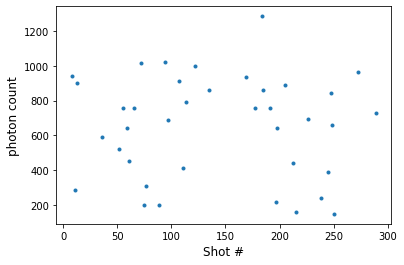

In [114]:
plt.plot(np.arange(len(mask_array_matrix[0]))[mask_array_matrix[0]],cavity_photoncount_array[mask_array_matrix[0],0],'.')
plt.xlabel('Shot #',fontsize=12)
plt.ylabel('photon count',fontsize=12)
# plt.xlim([0,300])

# Heterodyne analysis

In [115]:
amp_array = abs(cmplx_amp_array)
phase_array = np.unwrap(np.angle(cmplx_amp_array))
x_quad_array = np.real(cmplx_amp_array)
p_quad_array = np.imag(cmplx_amp_array)
t0_list = timebin_array[:,0]
t1_list = timebin_array[:,1]

time_select=np.array([t_pre+i*t_cav_frame for i in range(N_cycle)])

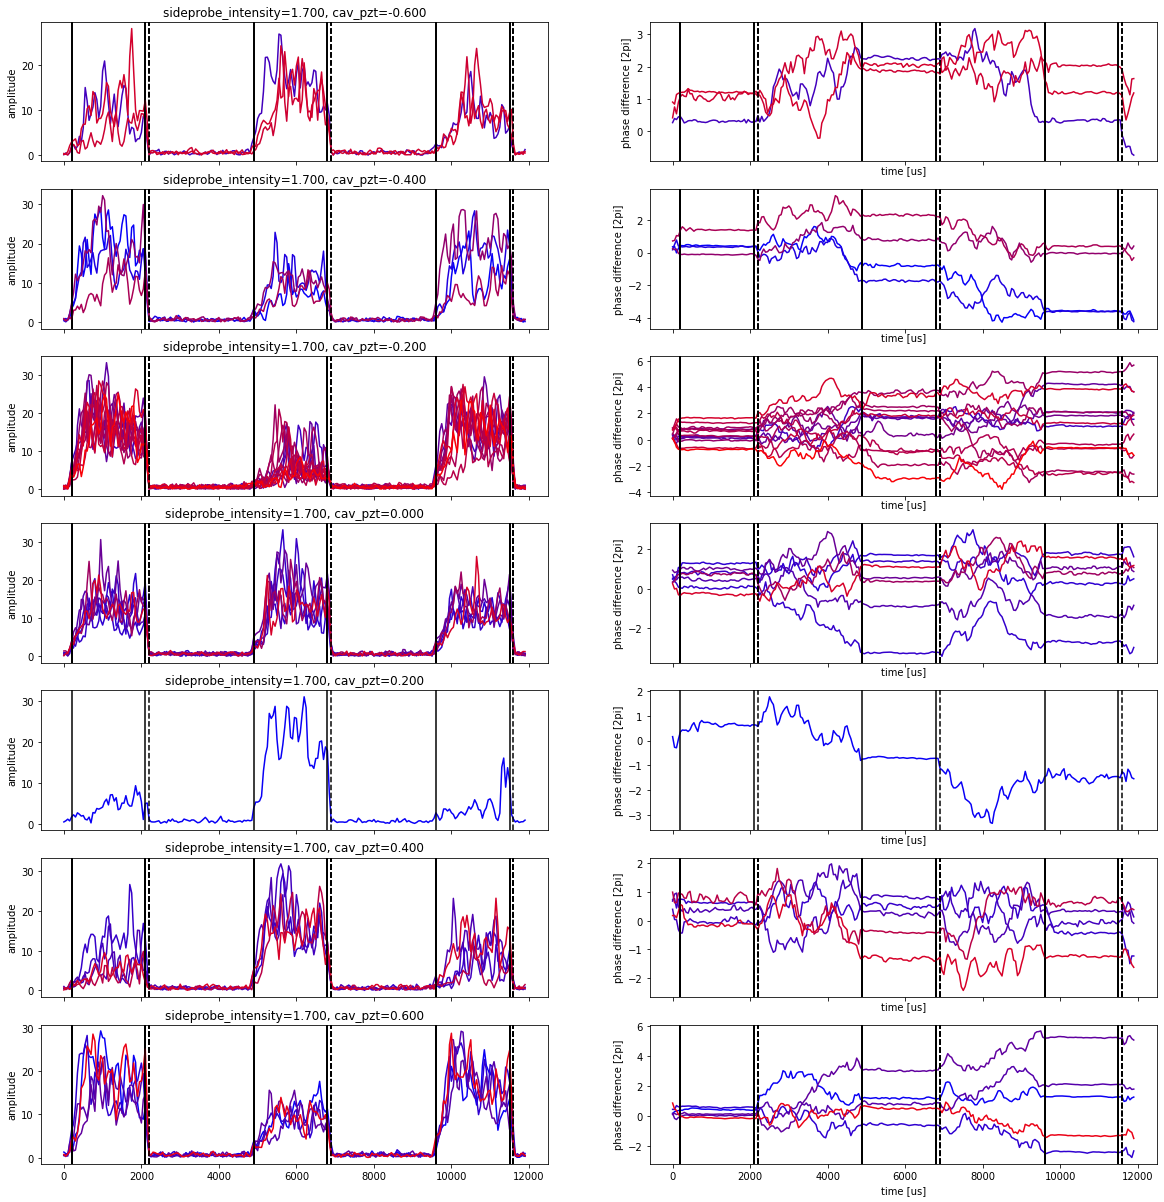

In [116]:



fig, axs = plt.subplots(ncols=2, nrows=num_points, sharex=True, figsize=(20,3*num_points))
for point_idx in range(len(point_list)):
    inner_idx = point_idx%num_points_inner
    outer_idx = point_idx//num_points_inner
    ind_x = point_idx
    corr_list = []
    for shot in range(num_shots_sliced):
        rcolor = shot/num_shots_sliced
        if mask_xval[ind_x][shot] & mask_array_matrix[0][shot]:
            if num_points > 1:
                plt.sca(axs[ind_x,0])
            else:
                plt.sca(axs[0])
            plt.plot(t0_list, amp_array[1,shot],c=(rcolor,0,1-rcolor)) #, label='het')
            plt.ylabel('amplitude')
            for t in time_select:
                plt.axvline(t, c='k')
                plt.axvline(t+t_probe, c='k',ls="--")
                plt.axvline(t+t_probe_het, c='k')
            plt.title(point_name_outer+'={:.3f}'.format(point_list_outer[outer_idx])+', '+\
                      point_name_inner+'={:.3f}'.format(point_list_inner[inner_idx]))
#             plt.xlim(11500,12500)

            if num_points > 1:
                plt.sca(axs[ind_x,1])
            else:
                plt.sca(axs[1])

            plt.plot(t0_list, (np.unwrap(((phase_array[0,shot]*2-phase_array[1,shot])%(2*np.pi)),period=2*np.pi)/np.pi/2),c=(rcolor,0,1-rcolor))
            corr_shot_temp = []
            amp_shot_temp = []
            for t in time_select:
                plt.axvline(t, c='k')
                plt.axvline(t+t_probe, c='k',ls="--")
                plt.axvline(t+t_probe_het, c='k')


            plt.xlabel('time [us]')
            plt.ylabel('phase difference [2pi]')


Text(0, 0.5, 'ch1 phase')

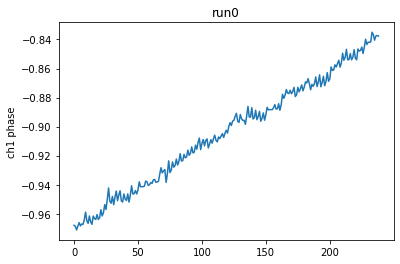

In [117]:
plt.plot(phase_array[0][0])
# plt.ylim(1.9,1.95)
plt.title(run_name)
plt.ylabel('ch1 phase')
# plt.xlim(0,1000)

[]

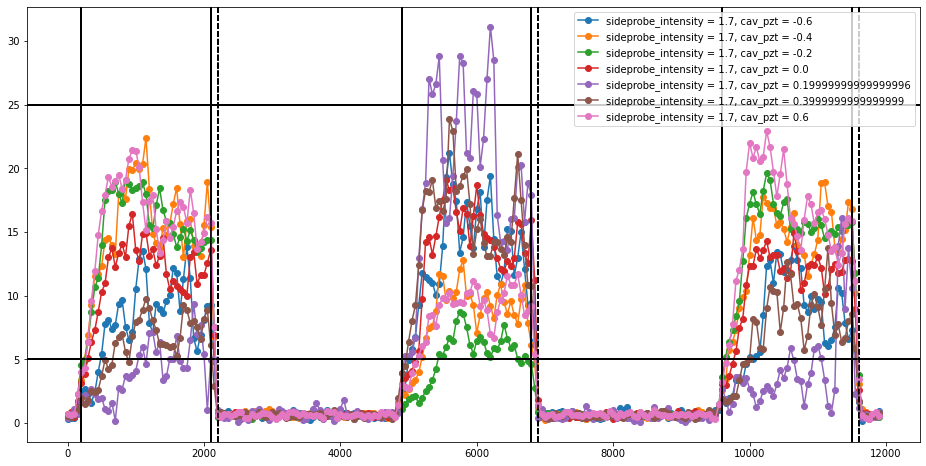

In [118]:

fig, axs = plt.subplots(ncols=1, nrows=num_points_outer, sharex=True, figsize=(16,8*num_points_outer))

for ind_x in range(num_points):
    count=0
    inner_idx = ind_x%num_points_inner
    outer_idx = 0 #ind_x//num_points_inner
    amp_avg = np.zeros(len(amp_array[1,0]))
    for shot in range(num_shots_sliced):
        if mask_xval[ind_x][shot] & mask_array_matrix[0][shot]:
            count+=1
            amp_avg += amp_array[1,shot]

    axs.plot(t0_list, amp_avg/count, 'o-', label = f"{point_name_outer} = {point_list_outer[outer_idx]}, {point_name_inner} = {point_list_inner[inner_idx]}")
    axs.axhline(25, c='k')
    axs.axhline(5, c='k')
    for t in time_select:
        axs.axvline(t, c='k')
        axs.axvline(t+t_probe, c='k',ls="--")
        axs.axvline(t+t_probe_het, c='k')
    axs.legend()

plt.plot()
    # plt.xlim(20,40)

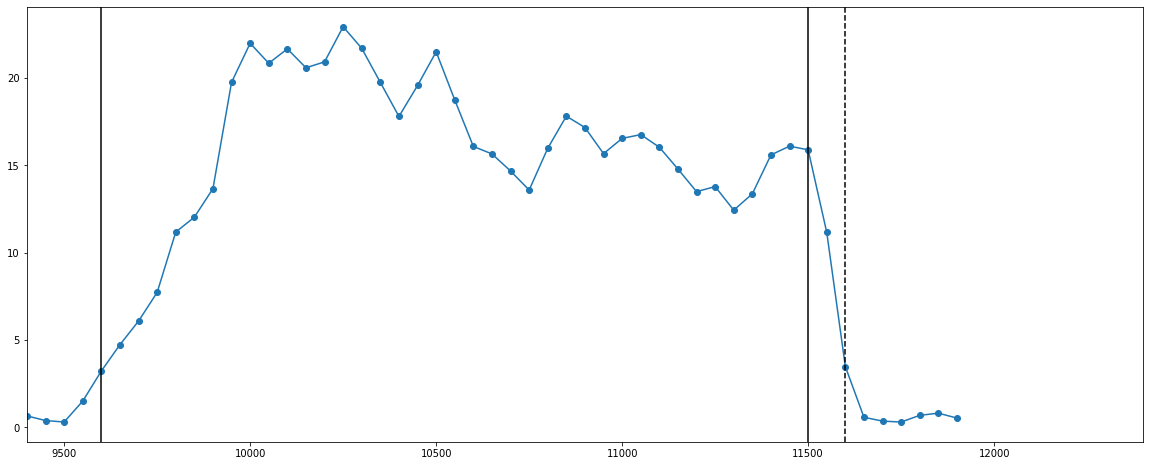

In [119]:
count=0
zoom_into_frame_num = num_frames_cav_per_twz -1

amp_avg = np.zeros(len(amp_array[1,0]))
for shot in range(num_shots_sliced):
    if mask_xval[ind_x][shot] & mask_array_matrix[0][shot]:
        count+=1
        amp_avg += amp_array[1,shot]
        
plt.figure(figsize=(20,8))
plt.plot(t0_list, amp_avg/count, 'o-')
plt.xlim(0+zoom_into_frame_num*t_cav_frame,3000+zoom_into_frame_num*t_cav_frame)

for t in time_select:
    plt.axvline(t, c='k')
    plt.axvline(t+t_probe, c='k',ls="--")
    plt.axvline(t+t_probe_het, c='k')

In [120]:
PHASE_CORRECTION = 0

frame_start=time_select
t_wiggle = 0 #us
phase_frame_array=[]
basephase_frame_array=[]
amp_frame_array=[]
x_quad_frame_array=[]
p_quad_frame_array=[]
for shot in range(num_shots_sliced): 
    basephase_frame_temp=[]
    phase_frame_temp=[]
    amp_frame_temp=[]
    real_frame_temp=[]
    imag_frame_temp=[]
    for i in range(N_cycle):
        mask_cycle = (t0_list > frame_start[i]-t_wiggle) & (t0_list < frame_start[i]+t_probe_het+t_wiggle)
        phase_array_ch1_temp = np.arctan2(p_quad_array[0,shot],x_quad_array[0,shot])
        phase_array_ch3_temp = np.arctan2(p_quad_array[1,shot],x_quad_array[1,shot])
        phase_frame_temp.append(list((phase_array_ch3_temp)[mask_cycle]))
        basephase_frame_temp.append(list((phase_array_ch1_temp*(2+PHASE_CORRECTION))[mask_cycle]))
        amp_frame_temp.append(list(np.sqrt(x_quad_array[1,shot][mask_cycle]**2+p_quad_array[1,shot][mask_cycle]**2)))
        real_frame_temp.append(list(x_quad_array[1,shot][mask_cycle]))
        imag_frame_temp.append(list(p_quad_array[1,shot][mask_cycle]))
    basephase_frame_array.append(basephase_frame_temp)
    phase_frame_array.append(phase_frame_temp)
    amp_frame_array.append(amp_frame_temp)
    x_quad_frame_array.append(real_frame_temp)
    p_quad_frame_array.append(imag_frame_temp)
basephase_frame_array=np.array(basephase_frame_array)
phase_frame_array=np.array(phase_frame_array)
amp_frame_array=np.array(amp_frame_array)
x_quad_frame_array=np.array(x_quad_frame_array)
p_quad_frame_array=np.array(p_quad_frame_array)

In [121]:
amp_frame_array_point = np.empty(num_points, dtype='object')
phase_frame_array_point=np.empty(num_points, dtype='object')
basephase_frame_array_point=np.empty(num_points, dtype='object')
x_quad_frame_array_point = np.empty(num_points, dtype='object')
p_quad_frame_array_point = np.empty(num_points, dtype='object')

for ind_x in range(num_points):
    mask_point = mask_xval[ind_x] & mask_array_matrix[0]
    amp_frame_array_point[ind_x]=amp_frame_array[mask_point]
    phase_frame_array_point[ind_x]=phase_frame_array[mask_point]
    basephase_frame_array_point[ind_x]=basephase_frame_array[mask_point]
    x_quad_frame_array_point[ind_x]=x_quad_frame_array[mask_point]
    p_quad_frame_array_point[ind_x]=p_quad_frame_array[mask_point]

num_masked_loop_list = [len(phase_frame_array_point[point]) for point in range(num_points)]
num_masked_loop_max = max(num_masked_loop_list)
num_masked_loop_min = min(num_masked_loop_list)

amp_frame_array_point_avg = np.empty((num_points, num_masked_loop_max, num_frames_cav))
amp_frame_array_point_avg[:] = np.nan
amp_frame_array_point_std = np.empty((num_points, num_masked_loop_max, num_frames_cav))
amp_frame_array_point_std[:] = np.nan
phase_frame_array_point_avg = np.empty((num_points, num_masked_loop_max, num_frames_cav))
phase_frame_array_point_avg[:] = np.nan
phase_frame_array_point_std = np.empty((num_points, num_masked_loop_max, num_frames_cav))
phase_frame_array_point_std[:] = np.nan
x_quad_frame_array_point_avg = np.empty((num_points, num_masked_loop_max, num_frames_cav))
x_quad_frame_array_point_avg[:] = np.nan
x_quad_frame_array_point_std = np.empty((num_points, num_masked_loop_max, num_frames_cav))
x_quad_frame_array_point_std[:] = np.nan
p_quad_frame_array_point_avg = np.empty((num_points, num_masked_loop_max, num_frames_cav))
p_quad_frame_array_point_avg[:] = np.nan
p_quad_frame_array_point_std = np.empty((num_points, num_masked_loop_max, num_frames_cav))
p_quad_frame_array_point_std[:] = np.nan

for ind_x in range(num_points):
    amp_frame_array_point_avg[ind_x][0:num_masked_loop_list[ind_x]] = np.nanmean(amp_frame_array_point[ind_x],axis=-1)
    amp_frame_array_point_std[ind_x][0:num_masked_loop_list[ind_x]] = np.nanstd(amp_frame_array_point[ind_x],axis=-1)
    phase_frame_array_point_avg[ind_x][0:num_masked_loop_list[ind_x]] = np.nanmean(phase_frame_array_point[ind_x],axis=-1)
    phase_frame_array_point_std[ind_x][0:num_masked_loop_list[ind_x]] = np.nanstd(phase_frame_array_point[ind_x],axis=-1)
    x_quad_frame_array_point_avg[ind_x][0:num_masked_loop_list[ind_x]] = np.nanmean(x_quad_frame_array_point[ind_x],axis=-1)
    x_quad_frame_array_point_std[ind_x][0:num_masked_loop_list[ind_x]] = np.nanstd(x_quad_frame_array_point[ind_x],axis=-1)
    p_quad_frame_array_point_avg[ind_x][0:num_masked_loop_list[ind_x]] = np.nanmean(p_quad_frame_array_point[ind_x],axis=-1)
    p_quad_frame_array_point_std[ind_x][0:num_masked_loop_list[ind_x]] = np.nanstd(p_quad_frame_array_point[ind_x],axis=-1)

Text(0, 0.5, 'average amp')

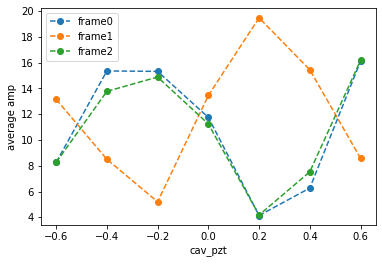

In [122]:
for frame in range(num_frames_cav):
    plt.plot(point_list_inner,np.nanmean(amp_frame_array_point_avg,axis=1)[:,frame],'o--', label=f'frame{frame}')
plt.legend()
plt.xlabel(point_name_inner)
plt.ylabel('average amp')

average phase SNR = 3.339543445241735


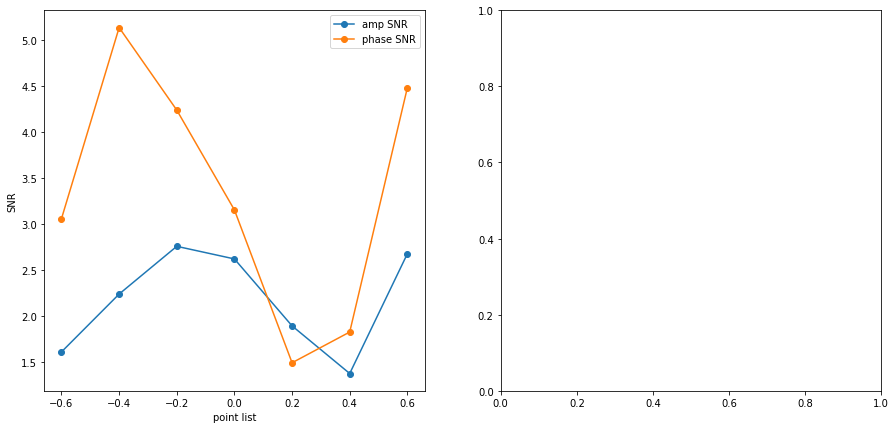

In [132]:
amp_mean_point_frame0 = np.empty(num_points)
amp_sigma_point_frame0 = np.empty(num_points)
phase_sigma_point_frame0 = np.empty(num_points)
frame=0
for point in range(num_points):
    amp_mean_point_frame0[point]=np.mean(np.concatenate(amp_frame_array_point[point][:,frame]))
    amp_sigma_point_frame0[point]=np.std(np.concatenate(amp_frame_array_point[point][:,frame]))
#     phase_sigma_point_frame0[point]=np.mean(np.std(np.unwrap(phase_frame_array_point[point][:,0]),axis=1))*amp_mean_point_frame0[point]
    phase_sigma_point_frame0[point]=np.mean([np.std(np.unwrap(phase_frame_array_point[point][ii,frame]),axis=-1) for ii in range(len(phase_frame_array_point[point]))])
fig,axs=plt.subplots(nrows=1,ncols=2, figsize=[15,7])
plt.sca(axs[0])
# plt.errorbar(point_list_inner, amp_mean_point_frame0**2, yerr=2*amp_mean_point_frame0*amp_err_point_frame0, label='frame0')
# plt.errorbar(point_list_inner, amp_mean_point_frame1**2, yerr=2*amp_mean_point_frame1*amp_err_point_frame1, label='frame1')
print(f"average phase SNR = {np.mean(1/phase_sigma_point_frame0)}")
plt.plot(point_list, amp_mean_point_frame0/amp_sigma_point_frame0, label="amp SNR",marker='o')
plt.plot(point_list, 1/phase_sigma_point_frame0, label="phase SNR",marker='o')
plt.xlabel("point list")
plt.ylabel('SNR')
plt.legend()
plt.show()

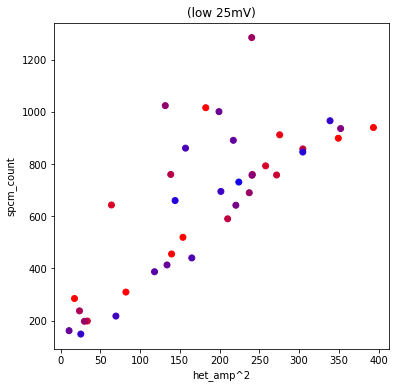

In [124]:
plt.figure(figsize=(6,6))
for point in range(num_points):
    inner_idx = point%num_points_inner
    outer_idx = point//num_points_inner
    mask_temp = mask_xval[point] & mask_array_matrix[0]
    plt.scatter(amp_frame_array_point_avg[point,:num_masked_loop_list[point],0]**2,\
                cavity_photoncount_array[mask_temp][:,0],label=f"{point_name_outer}={point_list_outer[outer_idx]:.3f}, {point_name_inner}={point_list_inner[inner_idx]:.3f}",\
                color=np.array([(1-ii/num_masked_loop_list[point],0,ii/num_masked_loop_list[point]) for ii in range(num_masked_loop_list[point])]))
    
plt.xlabel('het_amp^2')
plt.ylabel('spcm_count')
# plt.xlim(0,1500/71*25)
# plt.ylim(0,500/71*25)
plt.title("(low 25mV)")
# plt.legend(loc=(1,0))
plt.show()


# plt.figure(figsize=(6,6))
# for i in range(len(amp_frame_array_point_avg[0])):
#     plt.scatter(amp_frame_array_point_avg[point,i,1]**2,\
#                 cavity_photoncount_array[mask_array_matrix[0]][i,1],label=f"{i}-th valid shot")
    
# plt.xlabel('het_amp^2')
# plt.ylabel('spcm_count')
# plt.xlim(0,1500)
# plt.ylim(0,500)
# plt.title("(high 71mV)")
# # plt.legend(loc=(1,0))
# plt.show()





In [125]:
# # plt.figure(figsize=(8,8))
# num_shots_masked = len(amp_frame_array_point_avg[0])
# for group in range(1+(num_shots_masked-1)//6):
#     plt.figure(figsize=(6,6))
#     for i in range(group*6,min(group*6+6,num_shots_masked)):
#         plt.scatter(amp_frame_array_point_avg[point,i,0:5]**2,cavity_photoncount_array[mask_array_matrix[0]][i,0:5],label=f"{i}-th valid shot")
    
#     plt.xlabel('het_amp^2')
#     plt.ylabel('spcm_count')
#     plt.xlim(0,1300/3)
#     plt.ylim(0,400/3)
#     plt.title("Former 5 frames (low 26mV)")
#     plt.legend()
#     plt.show()

0
0
0


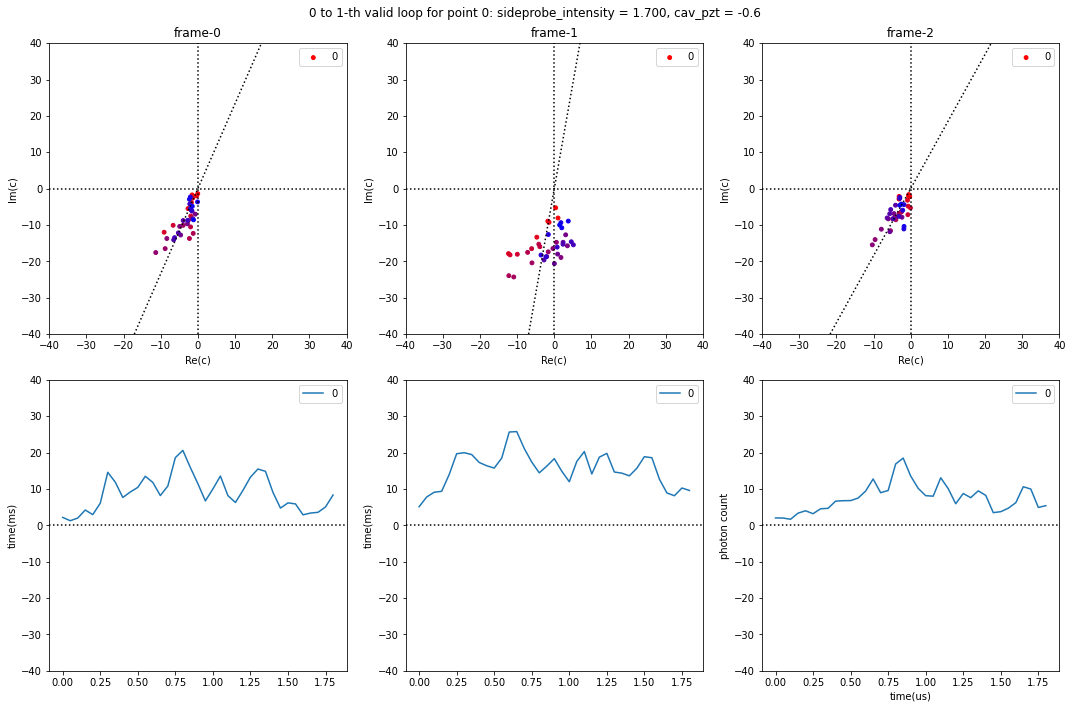

1
1
1


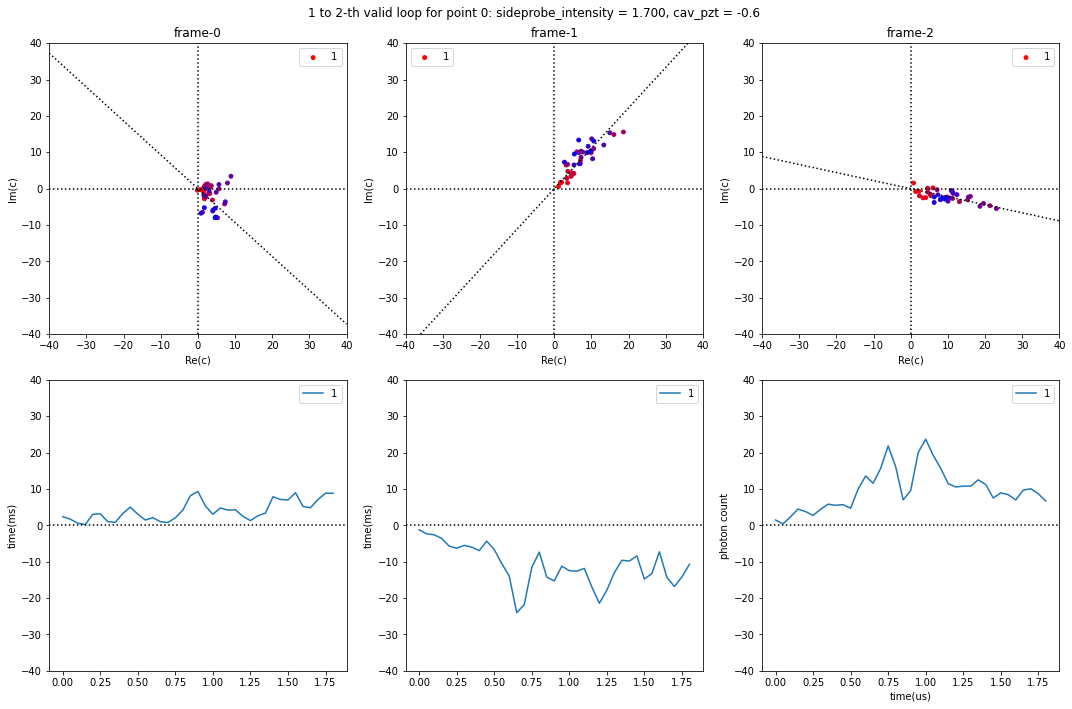

2
2
2


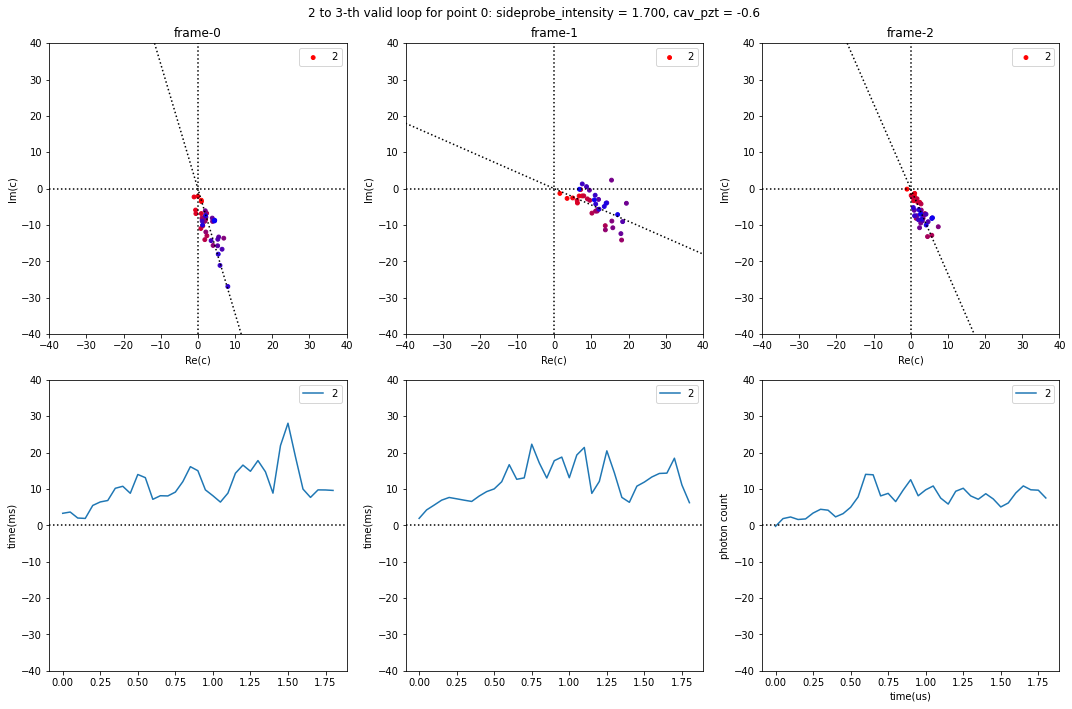

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


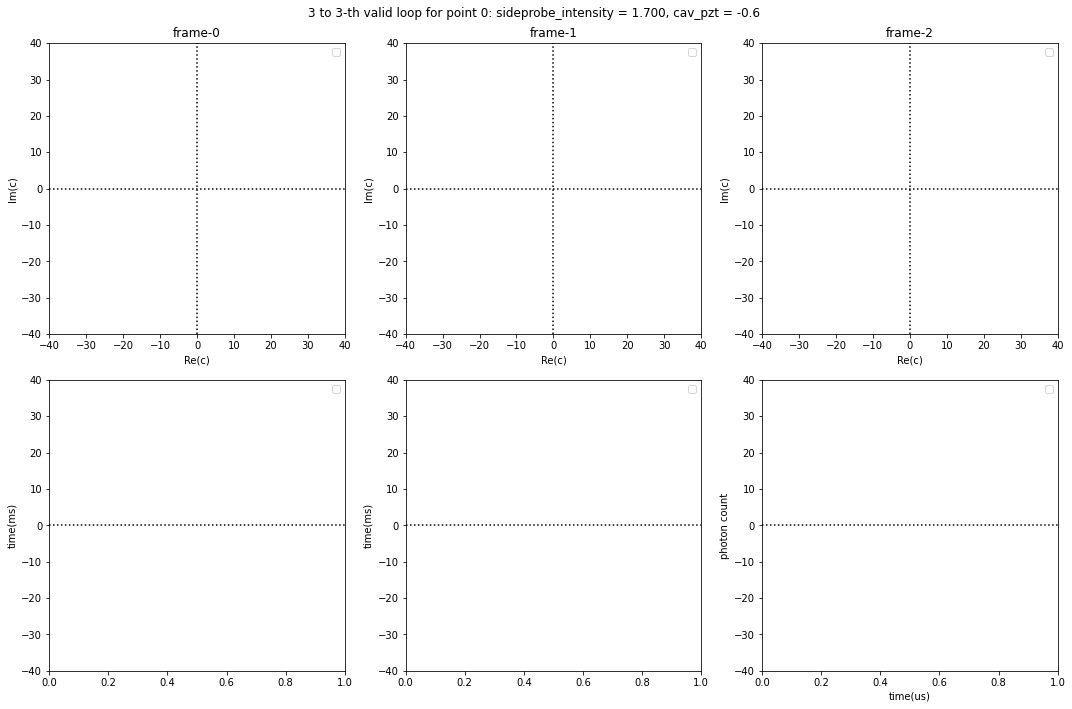

In [126]:
begin_frame = 0
end_frame = 0

group_loop_num = 1

outer_idx = 0
inner_idx = 0
point = outer_idx*num_points_inner + inner_idx
num_masked_loop_point=len(x_quad_frame_array_point[point])
for loop_group in range(num_masked_loop_point//group_loop_num+1):
    
#     plt.figure(figsize=(16,8))
    fig,axes = plt.subplots(nrows=2, ncols=3,figsize=(15,10))
            
    for frame in range(num_frames_cav):
#         row_num=frame%2
#         col_num=frame//2
        
        for i in range(loop_group*group_loop_num, min((loop_group+1)*group_loop_num, num_masked_loop_point)):
            print(i) #range(num_masked_loop_max-10,num_masked_loop_max):
            x = x_quad_frame_array_point[point][i,frame]
            y = p_quad_frame_array_point[point][i,frame]
#             print(x)
            theta0 = basephase_frame_array_point[point][i,frame]
            theta_print = np.mean(np.unwrap(phase_frame_array_point[point][i,frame]-theta0))
#             theta_begin = np.mean(np.unwrap(phase_frame_array_point[point][i,begin_frame]\
#                                             - basephase_frame_array_point[point][i,begin_frame])[-30:])
#             theta_end = np.mean(np.unwrap(phase_frame_array_point[point][i,end_frame]\
#                                          - basephase_frame_array_point[point][i,end_frame])[-30:])
#             theta_middle = np.mean(np.unwrap(phase_frame_array_point[point][i,1]\
#                                          - basephase_frame_array_point[point][i,1])[-30:])
#             while (theta_end-theta_begin > np.pi): theta_end -= 2*np.pi
#             while (theta_end-theta_begin < -np.pi): theta_end += 2*np.pi
#             theta_interpo = theta_begin + (theta_end-theta_begin)*(frame-begin_frame)/(end_frame-begin_frame)
#             if frame==2 and loop_group==0: plt.plot(np.unwrap(phase_frame_array_point[point][i,end_frame]\
#                                          - basephase_frame_array_point[point][i,end_frame]))
#             np.set_printoptions(precision=2)
#             print(np.arctan2(y,x), np.array(theta))
#             print("____________________________________")
#             ln = len(theta0)
            x_rotated = x*np.cos(theta0)+y*np.sin(theta0)
            y_rotated = -x*np.sin(theta0)+y*np.cos(theta0)
        
            cov_temp = np.array([[x_rotated@x_rotated,x_rotated@y_rotated],[x_rotated@y_rotated,y_rotated@y_rotated]])
            eigenValues, eigenVectors = np.linalg.eig(cov_temp)
            idx = eigenValues.argmax()
            direction = eigenVectors[:,idx]
            direction = direction / np.linalg.norm(direction)
            
            axes[0,frame].scatter(x_rotated, y_rotated, s=15, label=f'{i}',color=np.array([(1-ii/len(y),0,ii/len(y)) for ii in range(len(y))]))
            axes[0,frame].axline((0, 0), direction, ls=":", color='k')
            projected_amp = x_rotated*direction[0]+y_rotated*direction[1]
            axes[1,frame].plot(step_time*np.arange(len(x))/1000, projected_amp, label=f'{i}')
#             axes[frame].scatter(x*np.cos(theta0+theta_interpo)+y*np.sin(theta0+theta_interpo),\
#                                            -x*np.sin(theta0+theta_interpo)+y*np.cos(theta0+theta_interpo), \
#                                 color=np.array([(1-ii/len(y),0,ii/len(y)) for ii in range(len(y))]),\
#                                 label=f'{i},', s=4)
#         plt.figure()
        axes[0,frame].axhline(0,ls=":",c='k')
        axes[0,frame].axvline(0,ls=":",c='k')
        axes[0,frame].set_xlabel('Re(c)')
        axes[0,frame].set_ylabel('Im(c)')
    #     plt.gca().set_aspect('equal')
        axes[0,frame].set_xlim(-40,40)
        axes[0,frame].set_ylim(-40,40)
#         axes[row_num,col_num].legend()
        axes[0,frame].set_title(f"frame-{frame}")
        axes[0,frame].legend()
        axes[1,frame].axhline(0,ls=":",c='k')
        axes[1,frame].set_ylabel('projected c')
        axes[1,frame].set_ylabel('time(ms)')
        axes[1,frame].set_ylim(-40,40)
#         axes[row_num,col_num].legend()
        axes[1,frame].legend()


    plt.xlabel('time(us)')
    plt.ylabel('photon count')
    plt.suptitle(f"{loop_group*group_loop_num} to {min((loop_group+1)*group_loop_num, num_masked_loop_point)}-th valid loop for point {point}: {point_name_outer} = {point_list_outer[outer_idx]:.3f}, {point_name_inner} = {point_list_inner[inner_idx]} ")
    plt.tight_layout()
    plt.show()

Text(0, 0.5, 'average amplitude')

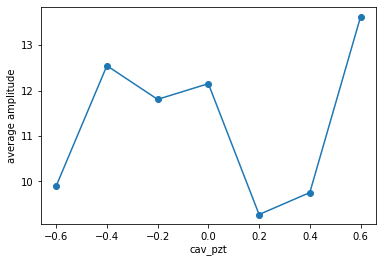

In [127]:
plt.plot(point_list_inner, np.nanmean(np.nanmean(amp_frame_array_point_avg,axis=1),axis=1),'o-')
plt.xlabel(point_name_inner)
plt.ylabel('average amplitude')

<Figure size 1152x576 with 0 Axes>

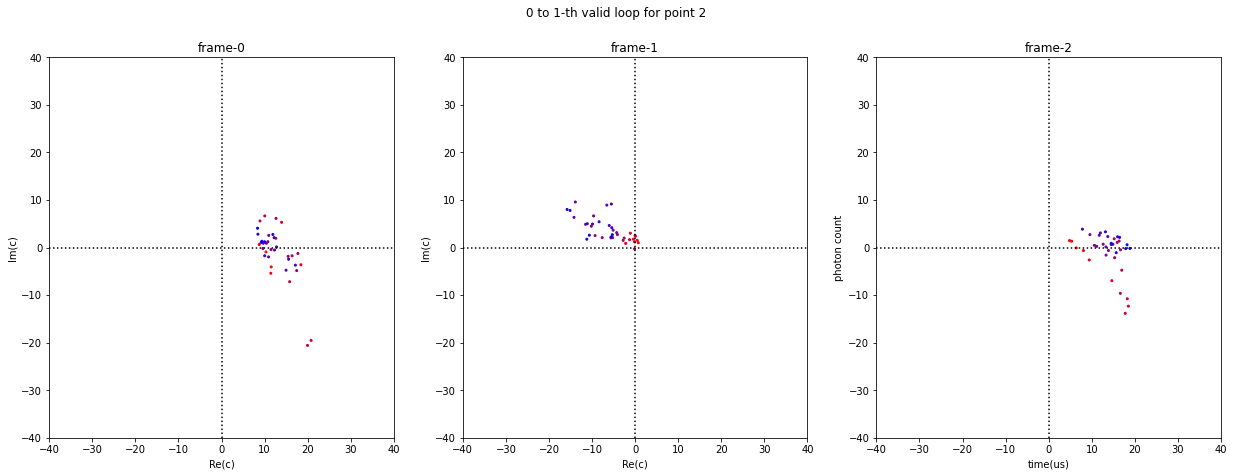

<Figure size 1152x576 with 0 Axes>

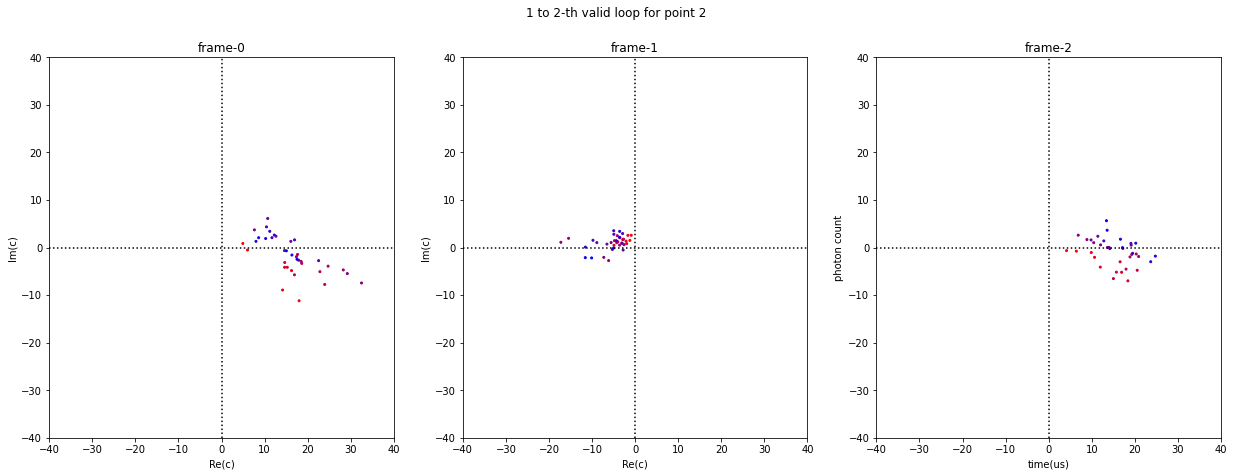

<Figure size 1152x576 with 0 Axes>

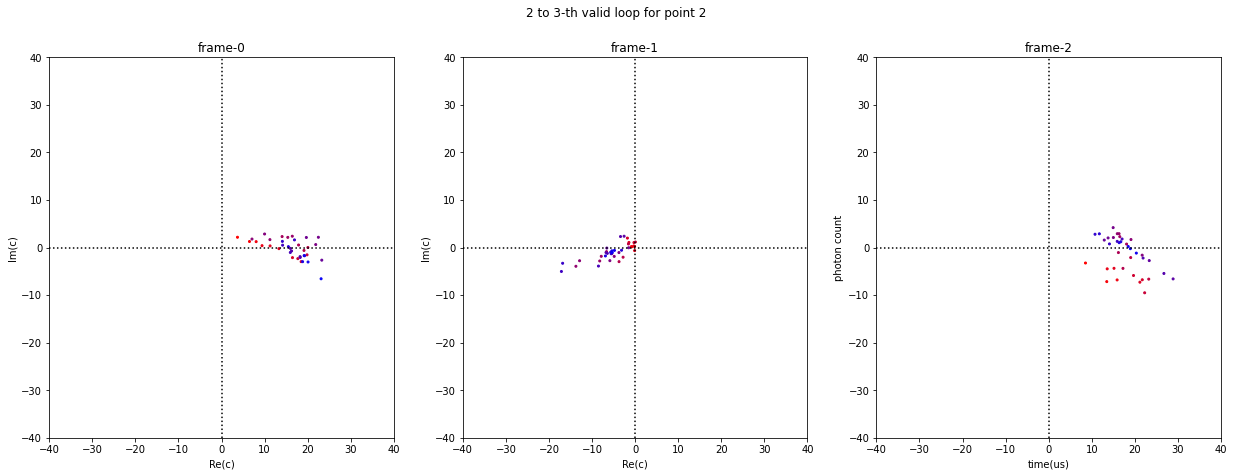

<Figure size 1152x576 with 0 Axes>

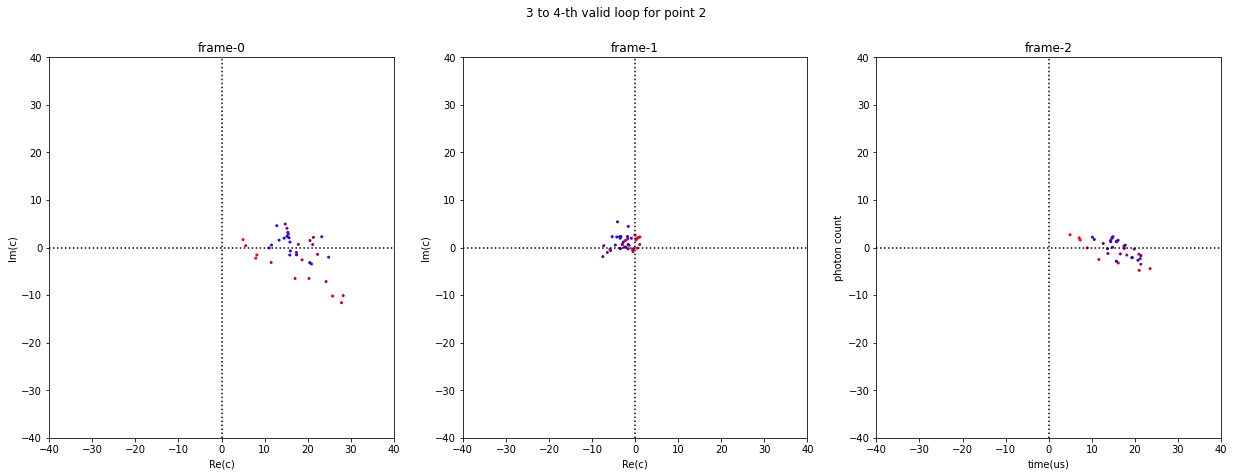

<Figure size 1152x576 with 0 Axes>

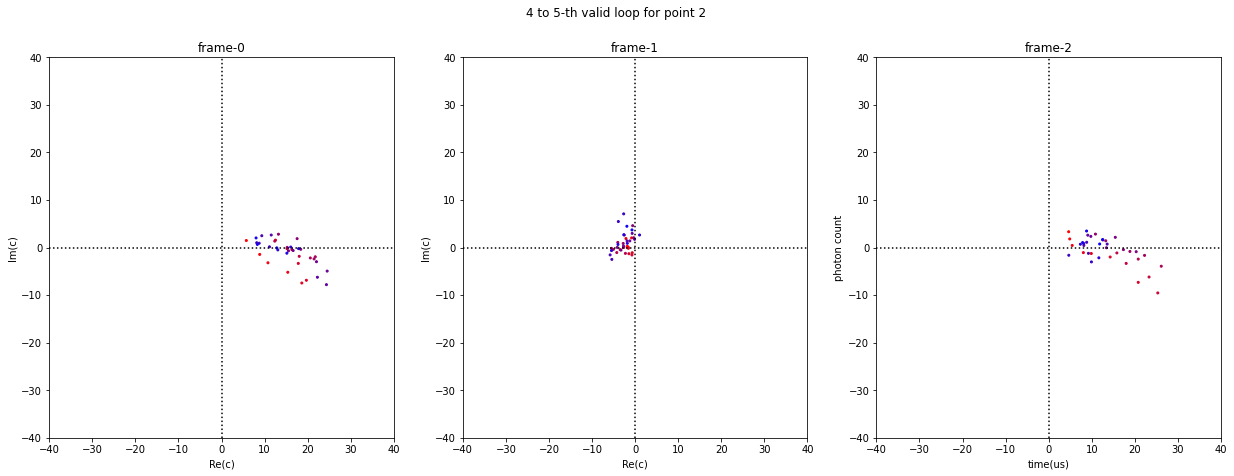

<Figure size 1152x576 with 0 Axes>

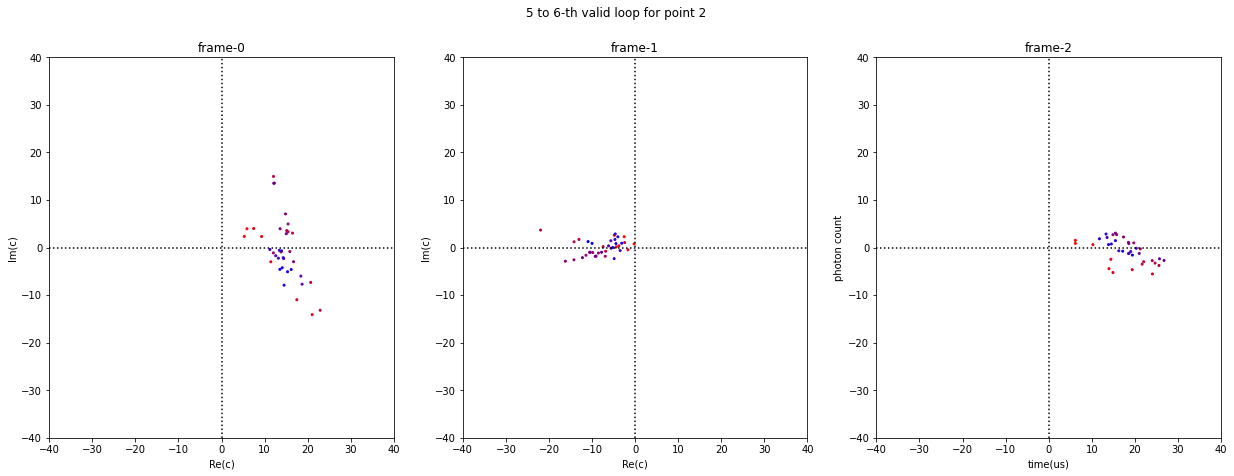

<Figure size 1152x576 with 0 Axes>

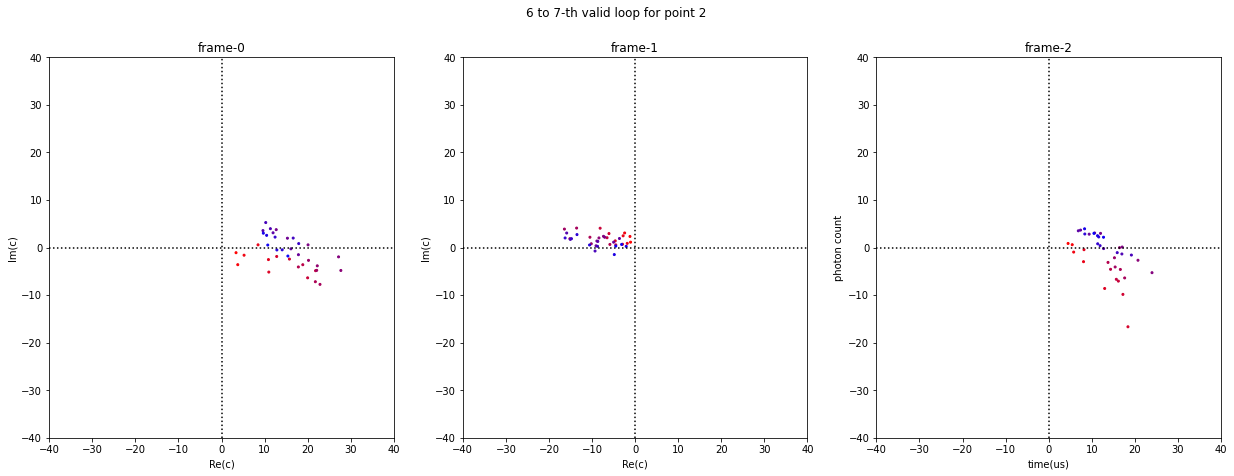

<Figure size 1152x576 with 0 Axes>

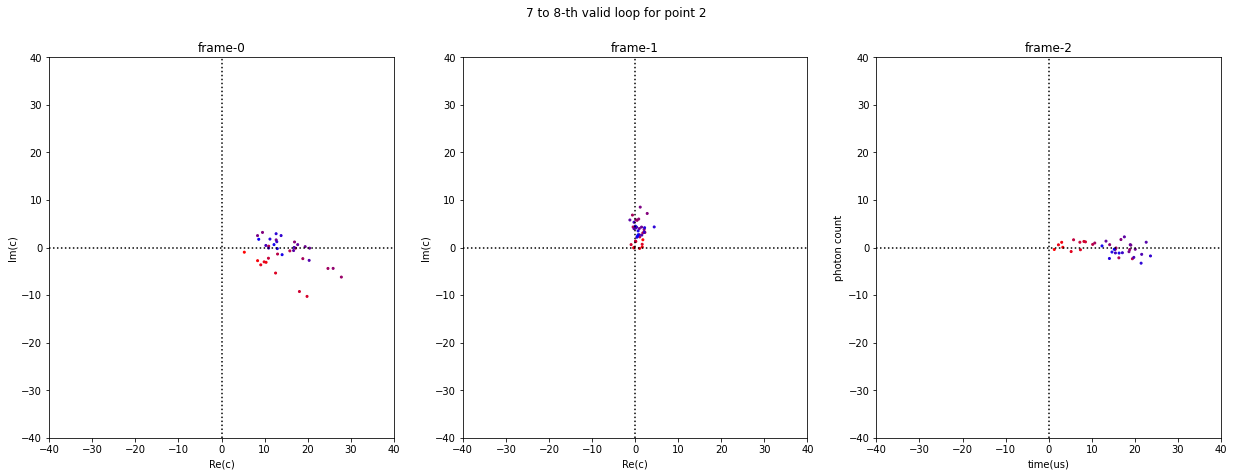

<Figure size 1152x576 with 0 Axes>

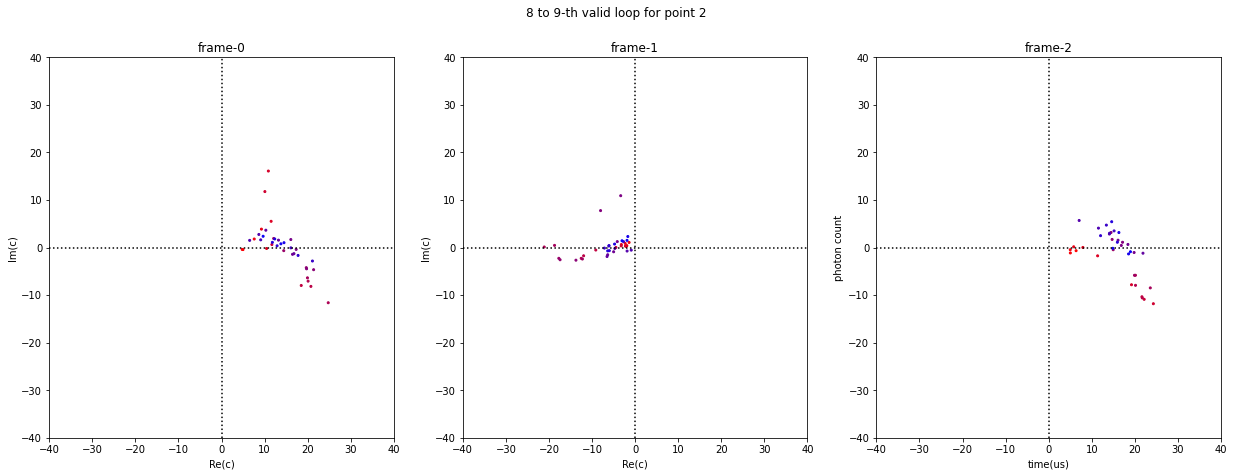

<Figure size 1152x576 with 0 Axes>

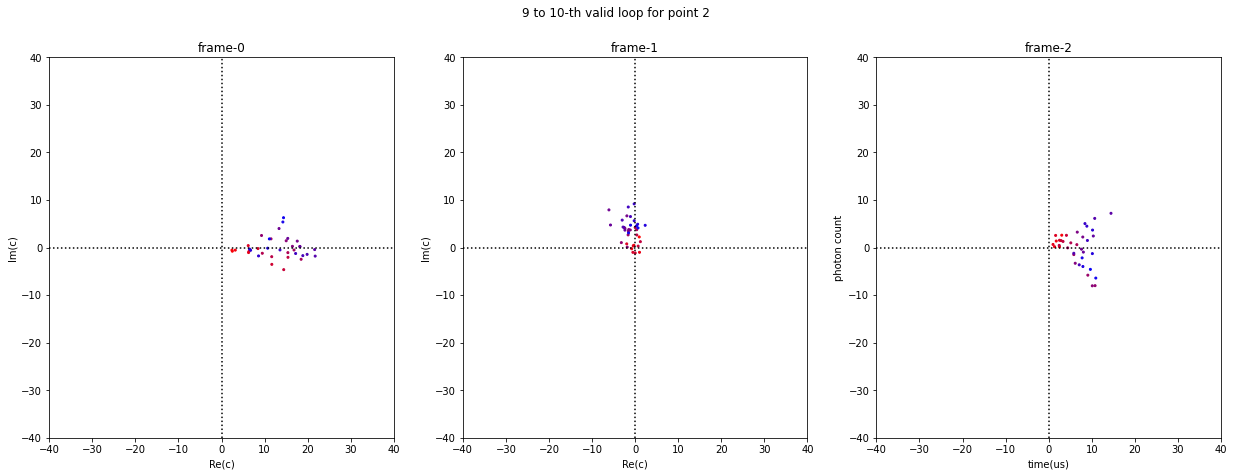

<Figure size 1152x576 with 0 Axes>

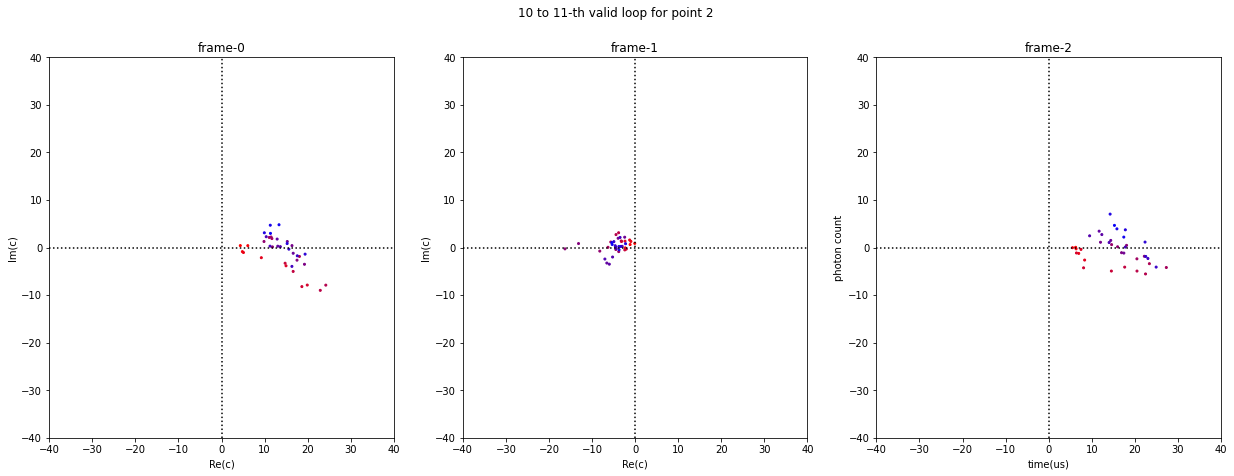

<Figure size 1152x576 with 0 Axes>

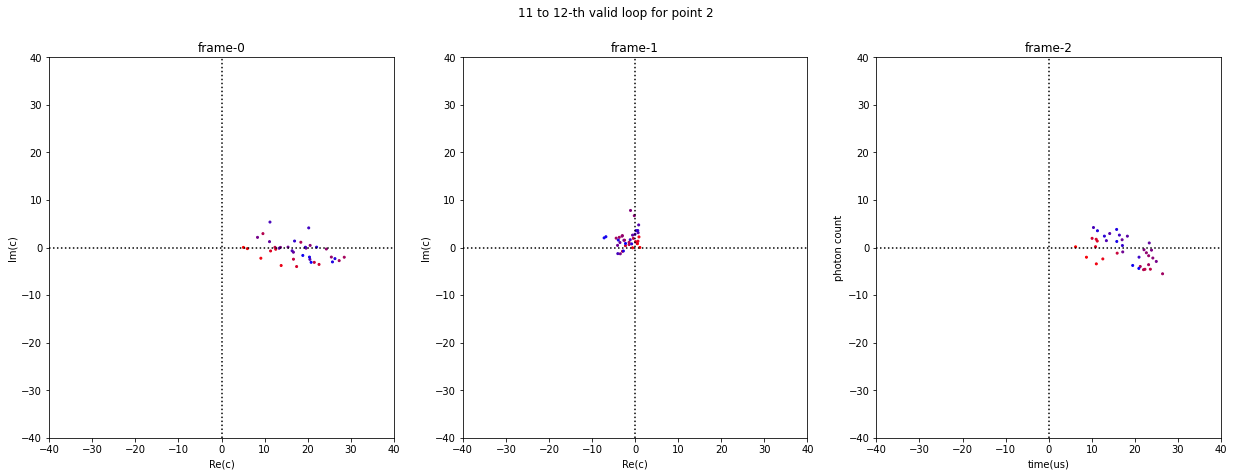

<Figure size 1152x576 with 0 Axes>

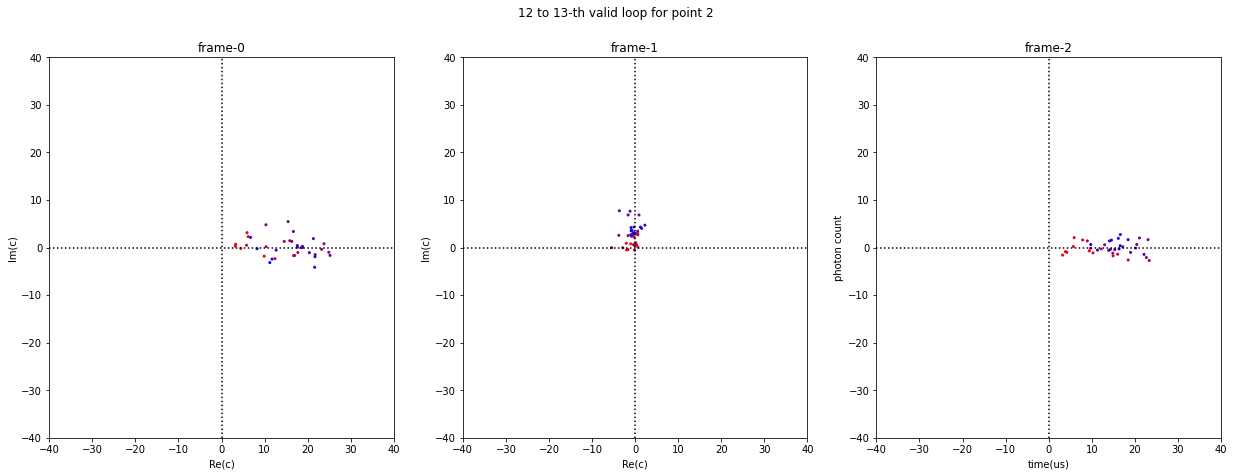

<Figure size 1152x576 with 0 Axes>

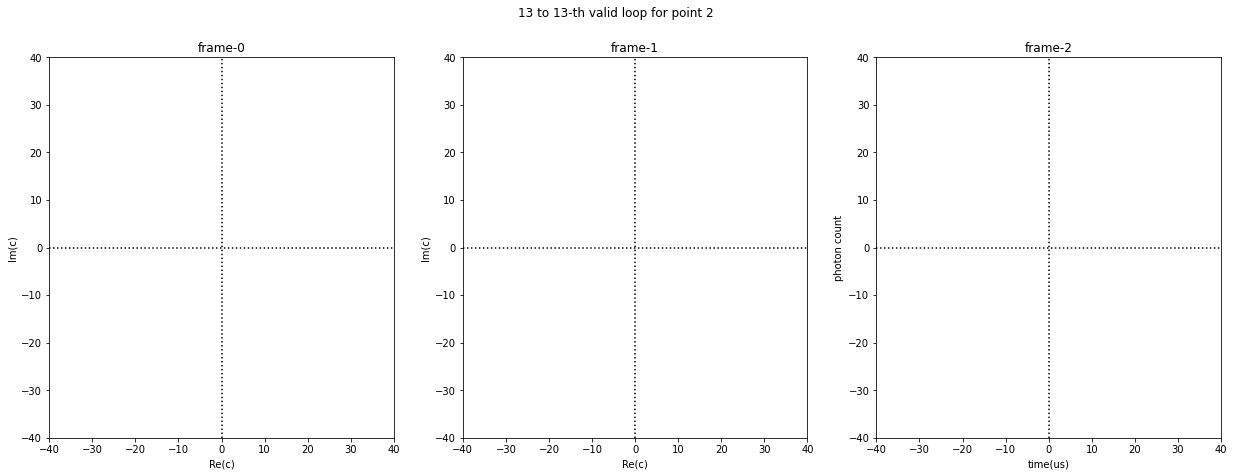

In [128]:
begin_frame = 0
end_frame = 2

group_loop_num = 1

for loop_group in range(num_masked_loop_max//group_loop_num+1):
    point = 2
    plt.figure(figsize=(16,8))
    fig,axes = plt.subplots(nrows=1, ncols=3,figsize=(21,7))
            
    for frame in range(3):
#         row_num=frame%2
#         col_num=frame//2
        num_masked_loop_point=len(x_quad_frame_array_point[point])
        for i in range(loop_group*group_loop_num, min((loop_group+1)*group_loop_num, num_masked_loop_point)): #range(num_masked_loop_max-10,num_masked_loop_max):
            x = x_quad_frame_array_point[point][i,frame]
            y = p_quad_frame_array_point[point][i,frame]
            
            theta0 = basephase_frame_array_point[point][i,frame]
            theta_print = np.mean(np.unwrap(phase_frame_array_point[point][i,frame]-theta0))
            theta_begin = np.mean(np.unwrap(phase_frame_array_point[point][i,begin_frame]\
                                            - basephase_frame_array_point[point][i,begin_frame])[-30:])
            theta_end = np.mean(np.unwrap(phase_frame_array_point[point][i,end_frame]\
                                         - basephase_frame_array_point[point][i,end_frame])[-30:])
            while (theta_end-theta_begin > np.pi): theta_end -= 2*np.pi
            while (theta_end-theta_begin < -np.pi): theta_end += 2*np.pi
            theta_interpo = theta_begin + (theta_end-theta_begin)*(frame-begin_frame)/(end_frame-begin_frame)
#             if frame==2 and loop_group==0: plt.plot(np.unwrap(phase_frame_array_point[point][i,end_frame]\
#                                          - basephase_frame_array_point[point][i,end_frame]))
#             np.set_printoptions(precision=2)
#             print(np.arctan2(y,x), np.array(theta))
#             print("____________________________________")
#             ln = len(theta0)
    #         plt.scatter(x0*np.cos(theta)+y0*np.sin(theta), -x0*np.sin(theta)+y0*np.cos(theta), c=[(j/ln,0,1-j/ln) for j in range(ln)], s=10, label=f'{i}')
            axes[frame].scatter(x*np.cos(theta0+theta_interpo)+y*np.sin(theta0+theta_interpo),\
                                           -x*np.sin(theta0+theta_interpo)+y*np.cos(theta0+theta_interpo), \
                                color=np.array([(1-ii/len(y),0,ii/len(y)) for ii in range(len(y))]),\
                                label=f'{i},', s=4)
#         plt.figure()
        axes[frame].axhline(0,ls=":",c='k')
        axes[frame].axvline(0,ls=":",c='k')
        axes[frame].set_xlabel('Re(c)')
        axes[frame].set_ylabel('Im(c)')
    #     plt.gca().set_aspect('equal')
        axes[frame].set_xlim(-40,40)
        axes[frame].set_ylim(-40,40)
#         axes[row_num,col_num].legend()
        axes[frame].set_title(f"frame-{frame}")


    plt.xlabel('time(us)')
    plt.ylabel('photon count')
    plt.suptitle(f"{loop_group*group_loop_num} to {min((loop_group+1)*group_loop_num, num_masked_loop_max)}-th valid loop for point {point}")
    plt.show()

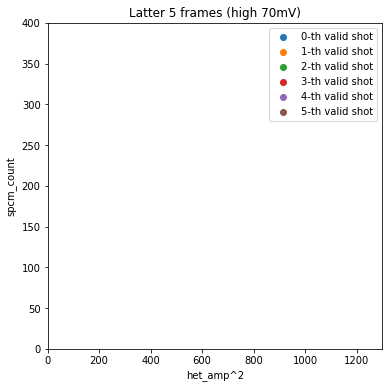

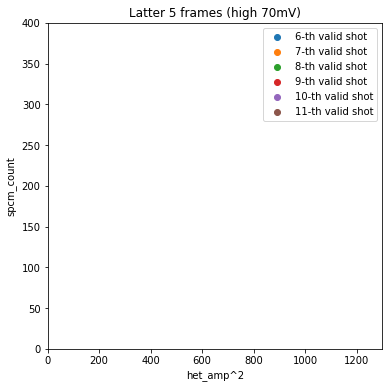

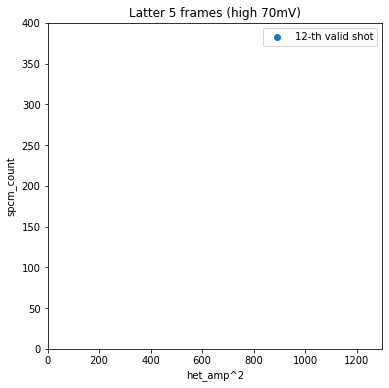

In [129]:
# plt.figure(figsize=(8,8))
num_shots_masked = len(amp_frame_array_point_avg[0])
for group in range(1+(num_shots_masked-1)//6):
    plt.figure(figsize=(6,6))
    for i in range(group*6,min(group*6+6,num_shots_masked)):
        plt.scatter(amp_frame_array_point_avg[point,i,5:num_frames_cav]**2,cavity_photoncount_array[mask_array_matrix[0]][i,5:num_frames_cav],label=f"{i}-th valid shot")
    
    plt.xlabel('het_amp^2')
    plt.ylabel('spcm_count')
    plt.xlim(0,1300)
    plt.ylim(0,400)
    plt.title("Latter 5 frames (high 70mV)")
    plt.legend()
    plt.show()

ValueError: shape mismatch: objects cannot be broadcast to a single shape

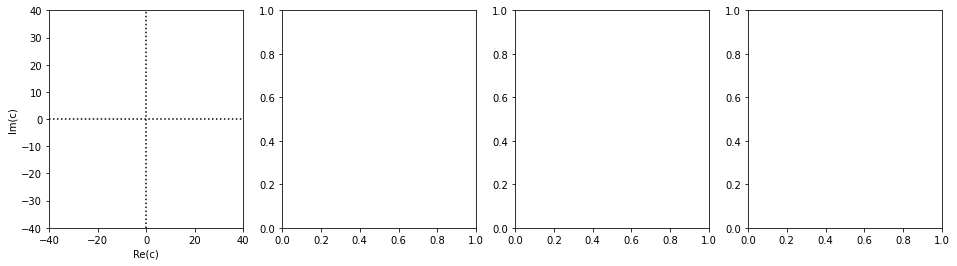

In [130]:

for point in range(num_points):
#     plt.figure(figsize=(16,8))
    for i in range(len(phase_frame_array_point[point])):
        fig,axes = plt.subplots(nrows=1, ncols=4,figsize=(16,4))
        for frame in range(5,num_frames_cav):
            x0 = x_quad_frame_array_point[point][i,frame]
            y0 = p_quad_frame_array_point[point][i,frame]
            theta = basephase_frame_array_point[point][i,frame]
            ln = len(theta)
    #         plt.scatter(x0*np.cos(theta)+y0*np.sin(theta), -x0*np.sin(theta)+y0*np.cos(theta), c=[(j/ln,0,1-j/ln) for j in range(ln)], s=10, label=f'{i}')
            axes[0].scatter(x0*np.cos(theta)+y0*np.sin(theta), -x0*np.sin(theta)+y0*np.cos(theta),  label=f'{i}', s=4)
#         plt.figure()
        axes[0].axhline(0,ls=":",c='k')
        axes[0].axvline(0,ls=":",c='k')
        axes[0].set_xlabel('Re(c)')
        axes[0].set_ylabel('Im(c)')
    #     plt.gca().set_aspect('equal')
        axes[0].set_xlim(-40,40)
        axes[0].set_ylim(-40,40)
        #################################################
#         axes[1].plot(amp_frame_array_point_avg[point,i,5:num_frames_cav]**2,marker="*")
        axes[1].bar(np.arange(5,10), amp_frame_array_point_avg[point,i,5:num_frames_cav]**2,color=['C0','C1','C2','C3','C4'])
        axes[1].set_ylim(0,1300)
#         axes[2].plot(cavity_photoncount_array[mask_array_matrix[0]][i,5:num_frames_cav],marker="*")
        axes[2].bar(np.arange(5,10),cavity_photoncount_array[mask_array_matrix[0]][i,5:num_frames_cav])
        axes[2].set_ylim(0,400)
        
#         mask_time = PT_cavity_timestamp_array_raw[mask_array_matrix[0]][i]>7000
        axes[3].plot(PT_cavity_timestamp_array_raw[mask_array_matrix[0]][i],np.arange(len(PT_cavity_timestamp_array_raw[mask_array_matrix[0]][i])),'.:',markersize=5,linewidth=0.5)
        axes[3].set_xlim(7000,14000)
        plt.xlabel('time(us)')
        plt.ylabel('photon count')
        plt.suptitle(f"{i}-th valid shot")
        plt.show()

In [ ]:
amp_1 = np.mean(amp_frame_array[:,0,:],axis=1)
amp_2 = np.mean(amp_frame_array[:,1,:],axis=1)
plt.plot(amp_1,amp_2,'o')
plt.plot([0,1e6],[0,1e6],'k--')

print(np.sum(amp_1>amp_2)/len(amp_1))

# Cavity timetrace plot

In [ ]:
plot_true = True
# if plot_true:
for x_val_plot in point_list:
#     x_val_plot = 1
    ind_x=np.argmin(np.abs(point_list_inner-x_val_plot))
    print(point_name_inner, point_list_inner[ind_x])

    fig,axs=plt.subplots(ncols=1,nrows=1,figsize=[8,3.6])
    plt.suptitle([point_name_inner, point_list_inner[ind_x]])
#     plt.sca(axs[0])

    for i in range(num_shots_sliced):
#     for i in np.arange(100,200):
        if mask_xval[ind_x][i] & mask_array_matrix[0][i]:
            plt.plot(PT_cavity_timestamp_array_raw[i],np.arange(len(PT_cavity_timestamp_array_raw[i])),'.:',markersize=5,linewidth=0.5)
            plt.xlabel('time(us)')
            plt.ylabel('photon count')
            for cav_frame in range(num_frames_cav_per_twz):
                plt.axvline(t_cav_start[cav_frame],c='k',linestyle=':',linewidth=1)
                plt.axvline(t_cav_end[cav_frame], c='k',linestyle='--',linewidth=1)
#                 plt.axvline(t_pre+1*t_probe + 0*t_mol)
#                 plt.axvline(t_pre+2*t_probe + 1*t_mol)


#     plt.xlim([0,700])
#     plt.ylim([0,100])
#     plt.xlim([0,74e3])
    
#     plt.ylim([-20,10000])
#     plt.ylim([-1,3])

#     plt.sca(axs[1])
#     gap_list_all = np.array([])
#     for i in range(num_shots_sliced):
#         if mask_xval[ind_x][i] & mask_full_0[i]:
#             gap_list_all = np.concatenate((gap_list_all, np.diff(PT_cavity_timestamp_array_raw[i])))
                
#     max_gap = max(gap_list_all)
#     hist_edge=np.arange(-0.5,max_gap+10,5)
#     hist_x=(hist_edge[:-1]+hist_edge[1:])/2
#     hist_y = np.histogram(gap_list_all,bins=hist_edge)[0] 
#     plt.bar(hist_x,hist_y,1, edgecolor="r",facecolor='r',alpha=0.6)
#     plt.yscale('log')

#     plt.xlim([t_cav_start[num_frames_cav_per_twz]-20,t_cav_end[2*num_frames_cav_per_twz-1]+10]);
#     plt.ylim([-20,100])

In [ ]:
i=0
plt.plot(PT_cavity_timestamp_array_raw[i],np.arange(len(PT_cavity_timestamp_array_raw[i])),'.:',markersize=5,linewidth=0.5)
plt.axvline([2365])
plt.xlim([2300,3000])

## Bin data

In [ ]:
# Bin data

mask_dark=((np.sum(atom_existence_array,axis=2)[:,0]==0) & (np.sum(atom_existence_array,axis=2)[:,1]==0) & mask_select)

if np.sum(mask_dark)>0:
    dark_count=np.mean(cavity_photoncount_array[mask_dark,1])
    print(dark_count)
    dark_count_rate=dark_count/(N_cycle*t_probe)
else:
    dark_count=0

num_array=len(twz_num_plot)

x_bin0_array_list=[[]]*num_array
photoncount_bin0_array_list=[[]]*num_array
photoncount_bin0_array_err_list=[[]]*num_array
photoncount_bin0_array_mean_err_list=[[]]*num_array

x_bin1_array_list=[[]]*num_array
photoncount_bin1_array_list=[[]]*num_array
photoncount_bin1_array_err_list=[[]]*num_array
photoncount_bin1_array_mean_err_list=[[]]*num_array

# TO DO: update the binning method to bin on x_val_corrected instead of x_val, actually maybe do both.
for array_ind in range(num_array):
    x_bin_temp,photoncount_bin_temp,photoncount_bin_temp_err,photoncount_bin_temp_mean_err=uniquebin(x_val[mask_array_matrix[array_ind]],cavity_photoncount_array[mask_array_matrix[array_ind],0])
    
    x_bin0_array_list[array_ind]=x_bin_temp
    photoncount_bin0_array_list[array_ind]=photoncount_bin_temp-dark_count
    photoncount_bin0_array_err_list[array_ind]=photoncount_bin_temp_err
    photoncount_bin0_array_mean_err_list[array_ind]=photoncount_bin_temp_mean_err
    
    x_bin_temp,photoncount_bin_temp,photoncount_bin_temp_err,photoncount_bin_temp_mean_err=uniquebin(x_val[mask_array_matrix[array_ind]],cavity_photoncount_array[mask_array_matrix[array_ind],1])
    
    x_bin1_array_list[array_ind]=x_bin_temp
    photoncount_bin1_array_list[array_ind]=photoncount_bin_temp-dark_count
    photoncount_bin1_array_err_list[array_ind]=photoncount_bin_temp_err
    photoncount_bin1_array_mean_err_list[array_ind]=photoncount_bin_temp_mean_err

In [ ]:
cavity_photoncount_array_postselected = cavity_photoncount_array[mask_array_matrix[0]]

In [ ]:
cavity_photoncount_array_postselected.shape

In [ ]:
plt.errorbar(np.arange(num_frames_cav), np.mean(cavity_photoncount_array[mask_array_matrix[0]]-dark_count, axis=0),
             yerr=np.std(cavity_photoncount_array[mask_array_matrix[0]]/np.sqrt(np.sum(mask_array_matrix[0])),axis=0))
plt.xlabel('frame')
plt.title('avg photon count/frame')

In [ ]:
low_count=np.mean(np.mean(cavity_photoncount_array[mask_array_matrix[0]]-dark_count,axis=0)[:5])
high_count=np.mean(np.mean(cavity_photoncount_array[mask_array_matrix[0]]-dark_count,axis=0)[-5:])
print(high_count/low_count)

In [ ]:
# show total photon counts
fig,axs=plt.subplots(ncols=2,nrows=1,figsize=[12,4],sharex=True,sharey=True)
plt.sca(axs[0])

for array_ind in range(num_array):
    plt.plot(x_val[mask_array_matrix[array_ind]], cavity_photoncount_array[:,0][mask_array_matrix[array_ind]]-dark_count, 'o', label=r'N={:.0f},frame0'.format(twz_num_plot[array_ind]),alpha=0.25)
for array_ind in range(num_array):
    plt.plot(x_val[mask_array_matrix[array_ind]], cavity_photoncount_array[:,1][mask_array_matrix[array_ind]]-dark_count, 'o', label=r'N={:.0f},frame1'.format(twz_num_plot[array_ind]),alpha=0.25)

        
plt.xlabel(point_name_inner,fontsize=14)
plt.ylabel('Photon Count',fontsize=14)
plt.legend()

plt.sca(axs[1])
for array_ind in range(num_array):
    plt.errorbar(x_bin0_array_list[array_ind], photoncount_bin0_array_list[array_ind],yerr=photoncount_bin0_array_mean_err_list[array_ind], marker='o', label=f'All atoms',alpha=0.9)

for array_ind in range(num_array):
    plt.errorbar(x_bin1_array_list[array_ind], photoncount_bin1_array_list[array_ind],yerr=photoncount_bin1_array_mean_err_list[array_ind], marker='o', label=f'All atoms',alpha=0.9)

    
plt.xlabel(point_name_inner,fontsize=14)
    
    
plt.tight_layout()
plt.show()

    


In [ ]:
cavity_photoncount_array.shape

In [ ]:
print(f'first frame counts = {np.mean(cavity_photoncount_array[:,0])}')
print(f'second frame counts = {np.mean(cavity_photoncount_array[:,1])}')

In [ ]:
# print(photoncount_bin_array_list[0])
# print(photoncount_bin_array_mean_err_list[0])

In [ ]:
# show total photon counts per atom

fig,axs=plt.subplots(ncols=2,nrows=1,figsize=[12,4],sharex=True,sharey=True)
plt.sca(axs[0])

for array_ind in range(num_array):
    plt.plot(x_val[mask_array_matrix[array_ind]], (cavity_photoncount_array[:,0][mask_array_matrix[array_ind]]-dark_count)/twz_num_plot[array_ind], 'o', label=r'N={:.0f}'.format(twz_num_plot[array_ind]),alpha=0.5)
plt.xlabel(point_name_inner,fontsize=14)
plt.ylabel('Photon Count per atom',fontsize=14)
plt.legend()

plt.sca(axs[1])
for array_ind in range(num_array):
    plt.errorbar(x_bin_array_list[array_ind], photoncount_bin_array_list[array_ind]/twz_num_plot[array_ind],yerr=photoncount_bin_array_mean_err_list[array_ind]/twz_num_plot[array_ind], marker='o', label=f'All atoms',alpha=0.9)
plt.xlabel(point_name_inner,fontsize=14)
    
    
plt.tight_layout()
plt.show()

In [ ]:

# plt.plot(np.arange(cavity_photoncount_array.shape[0])[mask_array_matrix[1] & mask_xval[8]],cavity_photoncount_array[:,0][mask_array_matrix[1] & mask_xval[8]])

## Averaged Time traces

In [ ]:
PT_cavity_timestamp_array_new = []

for shot_num in range(num_shots_sliced):
    PT_cavity_timestamp_array_cycles = []
    for i in range(N_cycle):
        timestamp_list = []
        for j in range(len(PT_cavity_timestamp_array_raw[shot_num])):   
            if t_pre + t_cycle*i < PT_cavity_timestamp_array_raw[shot_num][j] <= t_pre +t_cycle*i + t_probe:
                timestamp_list.append(PT_cavity_timestamp_array_raw[shot_num][j])
        PT_cavity_timestamp_array_cycles.append(timestamp_list)
    PT_cavity_timestamp_array_cycles = np.array(PT_cavity_timestamp_array_cycles)
    PT_cavity_timestamp_array_new.append(PT_cavity_timestamp_array_cycles)
# PT_cavity_timestamp_array_new = np.array(PT_cavity_timestamp_array_new)


In [ ]:
# bin the photon counts
bin_size = 50 #us
num_bins = int(t_probe/bin_size)
photon_number_binned = np.empty((num_shots, N_cycle, num_bins))
photon_number_binned[:] = np.NaN

for shot_num in range(num_shots_sliced):
    if mask_good_data[shot_num]:
        for i in range(N_cycle):      
            for bin_num in range(num_bins):
                count = 0
                for j in range(len(PT_cavity_timestamp_array_new[shot_num][i])):
                    if t_pre + t_cycle*i + bin_size*bin_num <= PT_cavity_timestamp_array_new[shot_num][i][j] < t_pre + t_cycle*i + bin_size*(bin_num+1):
                        count += 1
                photon_number_binned[shot_num][i][bin_num] = count

In [ ]:
photon_rate_timebin=np.zeros([len(twz_num_plot),num_points,num_bins])
photon_rate_timebin_err=np.zeros([len(twz_num_plot),num_points,num_bins])
for array_index,twz_num in enumerate(twz_num_plot):
    for point in range(num_points):
        for i in range(num_bins):
            photon_number_list_temp=photon_number_binned[mask_array_matrix[array_index]&mask_xval[point]][:,:,i].flatten()
            photon_rate_timebin[array_index,point,i]=np.mean(photon_number_list_temp)/bin_size
            photon_rate_timebin_err[array_index,point,i]=np.std(photon_number_list_temp)/bin_size/np.sqrt(len(photon_number_list_temp))

In [ ]:
plt.errorbar(bin_size*np.arange(num_bins),photon_rate_timebin[0,0],yerr=photon_rate_timebin_err[0,0], label=f'{point_name_inner} = {point_list[point]}')
# plt.errorbar()

In [ ]:
k=0

fig,ax=plt.subplots(ncols=1,nrows=1,figsize=[12,8])

for i in range(len(point_list)):
    plt.errorbar(bin_size*np.arange(num_bins),photon_rate_timebin[k,i],yerr=photon_rate_timebin_err[k,i],label=f'{point_name_inner}={round(point_list[i],1)}')
    
plt.legend()
# plt.xlim([-50,1100])

plt.xlabel('time t [us]',fontsize=16)
plt.ylabel('Photon count rate [$us^{-1}$]',fontsize=16)

In [ ]:
print(photon_rate_timebin[0][0][0])
print(photon_rate_timebin_err[0][0][0])

In [ ]:
plt.errorbar(point_list_inner, photon_rate_timebin[0][:,0], yerr=photon_rate_timebin_err[0][:,0]) # first bin photon count rate
plt.xlabel(point_name_inner)
plt.ylabel('initial photon count rate (MHz)')

### Fit Lorentzian with initial scattering rate

In [ ]:
# def lorentzian(x,x0,gamma,A):
#     return A*gamma**2/((x-x0)**2+gamma**2)

# detuning = point_list-f0_whole_run

# # detuning=point_list

# popt_lz_array=np.zeros([len(twz_num_plot),3])
# popt_lz_err_array=np.zeros([len(twz_num_plot),3])

# for i in range(len(twz_num_plot)):
    
#     x_plot=np.linspace(-4,3,601)
    
#     mask_fit_temp=~np.isnan(photon_rate_timebin[i,:,0])
    
#     x_fit_temp=detuning[mask_fit_temp]
#     y_fit_temp=photon_rate_timebin[i,mask_fit_temp,0]
#     y_fit_err_temp=photon_rate_timebin_err[i,mask_fit_temp,0]
    
# #     popt_lz,pcov_lz=curve_fit(lorentzian,x_fit_temp,y_fit_temp,p0=[x_fit_temp[np.argmax(y_fit_temp)],0.5,np.max(y_fit_temp)],sigma=y_fit_err_temp,absolute_sigma=True)
#     popt_lz,pcov_lz=curve_fit(lorentzian,x_fit_temp,y_fit_temp,p0=[x_fit_temp[np.argmax(y_fit_temp)],0.5,np.max(y_fit_temp)])
    
#     popt_lz_err=np.sqrt(np.diag(pcov_lz))
    
#     popt_lz_array[i]=popt_lz
#     popt_lz_err_array[i]=popt_lz_err
    
#     plt.errorbar(detuning,photon_rate_timebin[i,:,0]/twz_num_plot[i],yerr=photon_rate_timebin_err[i,:,0]/twz_num_plot[i],marker='o',markersize=5)
#     plt.plot(x_plot,lorentzian(x_plot,*popt_lz)/twz_num_plot[i])

#     plt.xlabel('Probe-Cavity Detuning (MHz)',fontsize=12)
#     plt.ylabel('Cavity Photon Rate per atom (ct/us)',fontsize=12)
    
#     print('N={:.0f}'.format(twz_num_plot[i]))
#     print('Spectrum shift = {:.3f}+/-{:.3f} MHz'.format(popt_lz[0],popt_lz_err[0]))
#     print('Spectrum width = {:.3f}+/-{:.3f} MHz'.format(popt_lz[1],popt_lz_err[1]))
#     print('Spectrum height = {:.3f}+/-{:.3f} ct/us'.format(popt_lz[2],popt_lz_err[2]))

In [ ]:
# plt.errorbar(detuning,photon_rate_timebin[1,:,0],yerr=photon_rate_timebin_err[1,:,0],marker='o',markersize=5)


### time traces

In [ ]:
# fig,axs=plt.subplots(ncols=2,nrows=1,figsize=[16,4],sharey=True)

# plt.sca(axs[0])

# for point in range(num_points):
#     freq_temp=point_list[point]-f0_whole_run-popt_lz[0]
#     if freq_temp<0:
# #         plt.plot(bin_size*np.arange(num_bins),photon_rate_timebin[point]/photon_rate_timebin[point][0],label=f'Detuning = {freq_temp:.2f}')

#         plt.errorbar(bin_size*np.arange(num_bins),photon_rate_timebin[point],yerr=photon_rate_timebin_err[point], label=f'Detuning = {freq_temp:.2f} MHz')

# plt.xlabel('time (us)')
# plt.ylabel('binned photon counts (ct/us)')
# plt.legend(fontsize=9)
# plt.xlim([-450,800])
# plt.title('Cavity Cooling',fontsize=15)

# plt.sca(axs[1])

# for point in range(num_points):
#     freq_temp=point_list[point]-f0_whole_run-popt_lz[0]
#     if freq_temp>0:
#         plt.errorbar(bin_size*np.arange(num_bins),photon_rate_timebin[point],yerr=photon_rate_timebin_err[point], label=f'Detuning = {freq_temp:.2f} MHz')

# plt.xlabel('time (us)')
# plt.ylabel('binned photon counts (ct/us)')
# plt.title('Cavity Heating',fontsize=15)
# plt.legend(fontsize=9)
# plt.xlim([-450,800])


### fit lorentzian with all data

In [ ]:
# x_plot=np.linspace(-4,3,601)

# detuning = point_list-f0_whole_run

# signal_all=(photoncount_bin_all_list[0]-3)/(N_cycle*t_probe)
# signal_all_err=photoncount_bin_all_err/(N_cycle*t_probe)

# popt_lz_all,pcov_lz_all=curve_fit(lorentzian,detuning,signal_all,p0=[detuning[np.argmax(signal_all)],0.5,np.max(signal_all)])
# popt_lz_all_err=np.sqrt(np.diag(pcov_lz_all))

# plt.errorbar(detuning,signal_all,yerr=signal_all_err,marker='o',markersize=5)
# plt.plot(x_plot,lorentzian(x_plot,*popt_lz_all))
# plt.xlabel('Probe-Cavity Detuning (MHz)',fontsize=12)
# plt.ylabel('Cavity Photon Rate (ct/us)',fontsize=12)

# print('Lorentzian fit with all recorded photon')
# print('Spectrum shift = {:.3f}+/-{:.3f} MHz'.format(popt_lz_all[0],popt_lz_all_err[0]))
# print('Spectrum width = {:.3f}+/-{:.3f} MHz'.format(popt_lz_all[1],popt_lz_all_err[1]))
# print('Spectrum height = {:.3f}+/-{:.3f} ct/us'.format(popt_lz_all[2],popt_lz_all_err[2]))



## Fit the oscillation

In [ ]:
def Oscillation_fitfun(x,x0,omega,ymax,ymin):
    return (ymax-ymin)/2*np.cos((x-x0)*omega)+(ymax+ymin)/2

In [ ]:
x_data_plot=[[]]*num_array
y_data_plot=[[]]*num_array
y_data_plot_err=[[]]*num_array

for array_ind in range(num_array):
    x_data_plot[array_ind]=x_bin_array_list[array_ind]
    y_data_plot[array_ind]=photoncount_bin_array_list[array_ind]
    y_data_plot_err[array_ind]=photoncount_bin_array_mean_err_list[array_ind]
    
#     x_data_plot[array_ind]=x_bin_array_list[array_ind]
#     y_data_plot[array_ind]=photon_rate_timebin[array_ind,:,0]-dark_count_rate
#     y_data_plot_err[array_ind]=photon_rate_timebin_err[array_ind,:,0]
    
#     mask=~np.isnan(y_data_plot[array_ind])
#     y_data_plot[array_ind]=y_data_plot[array_ind][mask]
#     y_data_plot_err[array_ind]=y_data_plot_err[array_ind][mask]
#     x_data_plot[array_ind]=x_data_plot[array_ind][mask]

In [ ]:
y_data_plot_err

In [ ]:
popt_array=[[]]*num_array
popt_err_array=[[]]*num_array
pcov_array=[[]]*num_array

contrast_array=np.zeros(num_array)
contrast_array_err=np.zeros(num_array)

conversion_array=np.zeros(num_array)
conversion_array_err=np.zeros(num_array)

maximum_array=np.zeros(num_array)
maximum_array_err=np.zeros(num_array)

maximum_position=np.zeros(num_array)
maximum_position_err=np.zeros(num_array)

for array_ind in range(num_array):
#     popt_temp,pcov_temp=curve_fit(Oscillation_fitfun,x_data_plot[array_ind], y_data_plot[array_ind],
#                                   p0=[x_data_plot[array_ind][np.argmax(y_data_plot[array_ind])],4,np.max(y_data_plot[array_ind]),np.min(y_data_plot[array_ind])])
    popt_temp,pcov_temp=curve_fit(Oscillation_fitfun,x_data_plot[array_ind], y_data_plot[array_ind],
                                  p0=[0,4.5,np.max(y_data_plot[array_ind]),np.min(y_data_plot[array_ind])])

    popt_temp_err=np.sqrt(np.diag(pcov_temp))
    
    popt_array[array_ind]=popt_temp
    popt_err_array[array_ind]=popt_temp_err
    pcov_array[array_ind]=pcov_temp
    
    contrast_array[array_ind]=(popt_temp[2]-popt_temp[3])/(popt_temp[2]+popt_temp[3])
    contrast_array_err[array_ind]=np.sqrt(popt_temp_err[2]**2+popt_temp_err[3])/(popt_temp[2]+popt_temp[3])
    
    conversion_array[array_ind]      = 390 * popt_temp[1]/(2*np.pi)
    conversion_array_err[array_ind]  = 390 * popt_temp_err[1]/(2*np.pi)
    
    maximum_array[array_ind]=popt_temp[2]
    maximum_array_err[array_ind]=popt_temp_err[2]
    
    maximum_position[array_ind]=popt_temp[0]
    maximum_position_err[array_ind]=popt_temp_err[0]

In [ ]:
# unit as photon count

xplot=np.linspace(np.min(point_list),np.max(point_list),201)

for array_ind in range(num_array):
    plt.errorbar(x_data_plot[array_ind], y_data_plot[array_ind]/twz_num_plot[array_ind],yerr=y_data_plot_err[array_ind]/twz_num_plot[array_ind],
                 marker='o', label=r'N={:.0f}'.format(twz_num_plot[array_ind]),alpha=0.9,color='C{:.0f}'.format(array_ind))
    plt.plot(xplot,Oscillation_fitfun(xplot,*popt_array[array_ind])/twz_num_plot[array_ind],linestyle='--')
plt.xlabel(point_name_inner,fontsize=14)
plt.ylabel('Photon Count per atom',fontsize=14)
plt.legend()

for array_ind,num in enumerate(twz_num_plot):
    print('============ N={:.0f} ============='.format(num))
    print('Contrast = {:.1f}+/-{:.1f}%'.format(contrast_array[array_ind]*100,contrast_array_err[array_ind]*100))
    print('Conversion = {:.1f}+/-{:.1f}'.format(conversion_array[array_ind],conversion_array_err[array_ind]))
    print('Maximum = {:.5f}+/-{:.5f}'.format(popt_array[array_ind][2],popt_err_array[array_ind][2]))
    print('Maximum Position = {:.2f}+/-{:.2f}'.format(maximum_position[array_ind],maximum_position_err[array_ind]))
    

In [ ]:
popt_array

In [ ]:
# unit as photon rate

xplot=np.linspace(np.min(point_list),np.max(point_list),201)

for array_ind in range(num_array):
    plt.errorbar(x_data_plot[array_ind], y_data_plot[array_ind]/twz_num_plot[array_ind],yerr=y_data_plot_err[array_ind]/twz_num_plot[array_ind],
                 marker='o', label=r'N={:.0f}'.format(twz_num_plot[array_ind]),alpha=0.9,color='C{:.0f}'.format(array_ind))
    plt.plot(xplot,Oscillation_fitfun(xplot,*popt_array[array_ind])/twz_num_plot[array_ind],linestyle='--')
plt.xlabel(point_name_inner,fontsize=14)
plt.ylabel('Photon rate per atom (ct/us)',fontsize=14)
plt.legend()

for array_ind,num in enumerate(twz_num_plot):
    print('============ N={:.0f} ============='.format(num))
    print('Contrast = {:.1f}+/-{:.1f}%'.format(contrast_array[array_ind]*100,contrast_array_err[array_ind]*100))
    print('Conversion = {:.1f}+/-{:.1f}'.format(conversion_array[array_ind],conversion_array_err[array_ind]))
    print('Maximum = {:.5f}+/-{:.5f}'.format(popt_array[array_ind][2],popt_err_array[array_ind][2]))
    

In [ ]:
popt,pcov=curve_fit(Oscillation_fitfun,x_data_plot[array_ind], photon_rate_timebin[0,:,0][1:],
                                  p0=[0,4.5,np.max(photon_rate_timebin[0,:,0][array_ind]),np.min(photon_rate_timebin[0,:,0][array_ind])])

In [ ]:
#plot bin0 counts
plt.errorbar(point_list,photon_rate_timebin[0,:,0],photon_rate_timebin_err[0,:,0])
# plt.plot(np.linspace(point_list[0], point_list[-1], 100), 
#          Oscillation_fitfun(np.linspace(point_list[0], point_list[-1], 100), *popt), '--')
print(f'contrast={(popt[2]-popt[3])/(popt[2]+popt[3])}')
plt.xlabel(f'{point_name_inner}')
plt.ylabel('Photon count rate [$us^{-1}$]',fontsize=16)